<a href="https://colab.research.google.com/github/cyberdreams8/water-quality-analysis-and-prediction-2/blob/main/PDS_waterquality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the necessary liabraries

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##Reading the Dataset

In [246]:
Dataset = pd.read_csv("https://raw.githubusercontent.com/cyberdreams8/water-quality-analysis-and-prediction-2/refs/heads/main/water_quality_dataset.csv")
Dataset

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability
0,0,15.0,"WELL AT KUYYURA, A.P.",ANDHRA PRADESH,23.0,28.0,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,Drinkable
1,1,16.0,WELL AT TADAVAI A.P.,ANDHRA PRADESH,27.0,28.0,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,Not Drinkable
2,2,26.0,"WELL AT VIJAYWADA, A.P.",ANDHRA PRADESH,26.0,32.0,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,Not Drinkable
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",ANDHRA PRADESH,26.0,27.0,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,Not Drinkable
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",ANDHRA PRADESH,25.0,30.0,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,Not Drinkable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,983,2533.0,SURI TOWN NEAR BUS STAND,WEST BENGAL,27.0,30.0,7.20,7.90,358.0,651.0,2021,7.840992,8.334117,6.326797,723.104180,472.638138,Not Drinkable
6312,984,1773.0,"TANGRA, CALCUTTA , WEST\nBENGAL",WEST BENGAL,28.0,31.0,7.30,7.40,1435.0,1730.0,2021,4.675666,NaN,5.193830,230.164378,234.763384,Not Drinkable
6313,985,1774.0,"TOPSIA CALCUTTA, WEST\nBENGAL",WEST BENGAL,29.0,31.0,7.30,7.30,1705.0,1921.0,2021,6.479175,5.978842,6.091671,920.225147,123.066151,Not Drinkable
6314,986,2546.0,ULUBERIA COLLEGE AT HOWRAH,WEST BENGAL,26.0,30.0,7.20,7.60,909.0,1090.0,2021,1.465082,8.737017,6.525324,480.030896,373.339982,Not Drinkable


In [247]:
Dataset.columns

Index(['Unnamed: 0', 'Station Code', 'Station Name', 'STATE',
       'Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
       'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max', 'Year',
       'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)',
       'TDS (mg/L)', 'Hardness (mg/L)', 'Potability'],
      dtype='object')

In [248]:
Dataset

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability
0,0,15.0,"WELL AT KUYYURA, A.P.",ANDHRA PRADESH,23.0,28.0,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,Drinkable
1,1,16.0,WELL AT TADAVAI A.P.,ANDHRA PRADESH,27.0,28.0,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,Not Drinkable
2,2,26.0,"WELL AT VIJAYWADA, A.P.",ANDHRA PRADESH,26.0,32.0,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,Not Drinkable
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",ANDHRA PRADESH,26.0,27.0,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,Not Drinkable
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",ANDHRA PRADESH,25.0,30.0,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,Not Drinkable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,983,2533.0,SURI TOWN NEAR BUS STAND,WEST BENGAL,27.0,30.0,7.20,7.90,358.0,651.0,2021,7.840992,8.334117,6.326797,723.104180,472.638138,Not Drinkable
6312,984,1773.0,"TANGRA, CALCUTTA , WEST\nBENGAL",WEST BENGAL,28.0,31.0,7.30,7.40,1435.0,1730.0,2021,4.675666,NaN,5.193830,230.164378,234.763384,Not Drinkable
6313,985,1774.0,"TOPSIA CALCUTTA, WEST\nBENGAL",WEST BENGAL,29.0,31.0,7.30,7.30,1705.0,1921.0,2021,6.479175,5.978842,6.091671,920.225147,123.066151,Not Drinkable
6314,986,2546.0,ULUBERIA COLLEGE AT HOWRAH,WEST BENGAL,26.0,30.0,7.20,7.60,909.0,1090.0,2021,1.465082,8.737017,6.525324,480.030896,373.339982,Not Drinkable


In [249]:
Dataset.head()

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability
0,0,15.0,"WELL AT KUYYURA, A.P.",ANDHRA PRADESH,23.0,28.0,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,Drinkable
1,1,16.0,WELL AT TADAVAI A.P.,ANDHRA PRADESH,27.0,28.0,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,Not Drinkable
2,2,26.0,"WELL AT VIJAYWADA, A.P.",ANDHRA PRADESH,26.0,32.0,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,Not Drinkable
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",ANDHRA PRADESH,26.0,27.0,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,Not Drinkable
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",ANDHRA PRADESH,25.0,30.0,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,Not Drinkable


In [250]:
Dataset.tail()

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability
6311,983,2533.0,SURI TOWN NEAR BUS STAND,WEST BENGAL,27.0,30.0,7.2,7.9,358.0,651.0,2021,7.840992,8.334117,6.326797,723.104180,472.638138,Not Drinkable
6312,984,1773.0,"TANGRA, CALCUTTA , WEST\nBENGAL",WEST BENGAL,28.0,31.0,7.3,7.4,1435.0,1730.0,2021,4.675666,NaN,5.193830,230.164378,234.763384,Not Drinkable
6313,985,1774.0,"TOPSIA CALCUTTA, WEST\nBENGAL",WEST BENGAL,29.0,31.0,7.3,7.3,1705.0,1921.0,2021,6.479175,5.978842,6.091671,920.225147,123.066151,Not Drinkable
6314,986,2546.0,ULUBERIA COLLEGE AT HOWRAH,WEST BENGAL,26.0,30.0,7.2,7.6,909.0,1090.0,2021,1.465082,8.737017,6.525324,480.030896,373.339982,Not Drinkable
6315,987,2535.0,VISVA BHARATI,WEST BENGAL,30.0,31.0,7.9,8.2,370.0,437.0,2021,0.678409,4.987829,5.729190,578.810775,51.550765,Not Drinkable


##Sanity Check of Data

In [251]:
Dataset.shape

(6316, 17)

In [252]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   6316 non-null   int64  
 1   Station Code                 6240 non-null   float64
 2   Station Name                 6267 non-null   object 
 3   STATE                        6241 non-null   object 
 4   Temperature Min              5818 non-null   float64
 5   Temperature Max              5818 non-null   float64
 6   pH Min                       6195 non-null   float64
 7   pH Max                       6195 non-null   float64
 8   Conductivity (µmhos/cm) Min  6124 non-null   float64
 9   Conductivity (µmhos/cm) Max  6124 non-null   float64
 10  Year                         6316 non-null   int64  
 11  Turbidity (NTU)              6255 non-null   float64
 12  Dissolved Oxygen (mg/L)      6253 non-null   float64
 13  BOD (mg/L)        

In [253]:
#finding missing values
Dataset.isnull().sum()

,0
Unnamed: 0,0
Station Code,76
Station Name,49
STATE,75
Temperature Min,498
Temperature Max,498
pH Min,121
pH Max,121
Conductivity (µmhos/cm) Min,192
Conductivity (µmhos/cm) Max,192


In [254]:
#finding missing values in percentage
Dataset.isnull().sum()/Dataset.shape[0]*100

,0
Unnamed: 0,0.000000
Station Code,1.203293
Station Name,0.775807
STATE,1.187460
Temperature Min,7.884737
Temperature Max,7.884737
pH Min,1.915769
pH Max,1.915769
Conductivity (µmhos/cm) Min,3.039899
Conductivity (µmhos/cm) Max,3.039899


In [255]:
#finding duplicates
Dataset.duplicated().sum()

0

In [256]:
#identifying garbage values
for i in Dataset.select_dtypes(include='object').columns:
  print(Dataset[i].value_counts())
  print("***"*10)

Station Name
BEGUSARAI                                                                                    10
PATNA                                                                                        10
FULBARI BARRAGE                                                                               9
NANGAL, PUNJAB                                                                                9
VISVA BHARATI                                                                                 9
                                                                                             ..
HAND PUMP WATER NEAR D.M OFFICE, MADHEPURA                                                    1
HAND PUMP WATER AT COLLECTRIATE OFFICE, MADHUBANI                                             1
TAP WATER INSIDE THE CAMPUS OF TOURIST CAFETERIA,\nNALANDA                                    1
HAND PUMP WATER AT CIVIL COURT, NALANDA                                                       1
GROUND WATER AT BHAGWAN\nIN

##Exploratory Data Analysis (EDA)

In [257]:
Dataset.columns

Index(['Unnamed: 0', 'Station Code', 'Station Name', 'STATE',
       'Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
       'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max', 'Year',
       'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)',
       'TDS (mg/L)', 'Hardness (mg/L)', 'Potability'],
      dtype='object')

In [258]:
#descriptive statistics
columns= ['Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
       'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max',
       'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)',
       'TDS (mg/L)', 'Hardness (mg/L)']
selected_data = Dataset[columns]
selected_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature Min,5818.0,25.243589,4.694067,0.000000,23.000000,26.000000,28.000000,67.000000
Temperature Max,5818.0,27.175799,4.515805,0.000000,25.000000,28.000000,30.000000,70.000000
pH Min,6195.0,7.155052,0.698224,0.000000,6.900000,7.200000,7.600000,9.600000
pH Max,6195.0,7.631516,8.849163,4.600000,7.200000,7.510000,7.900000,702.000000
Conductivity (µmhos/cm) Min,6124.0,1303.856199,3102.087896,0.000000,294.000000,680.000000,1338.500000,72683.000000
Conductivity (µmhos/cm) Max,6124.0,1728.061300,3725.717739,0.000000,415.750000,895.000000,1748.250000,87790.000000
Turbidity (NTU),6255.0,7.039597,4.422660,0.082832,2.939743,6.841050,10.944093,14.803304
Dissolved Oxygen (mg/L),6253.0,7.468643,2.875296,2.136340,5.182620,7.811954,10.059789,11.946842
BOD (mg/L),6259.0,3.725973,2.437790,0.014496,1.445302,3.481846,5.852835,7.968710
TDS (mg/L),6253.0,1087.243968,589.160839,110.759701,529.066337,1043.741646,1678.590777,1979.440543


In [259]:
selected_data2 = Dataset[['STATE','Potability']]
selected_data2.describe().T

,count,unique,top,freq
STATE,6241,53,RAJASTHAN,585
Potability,6316,2,Not Drinkable,6047


In [260]:
# prompt: upsample minority of potability

# Assuming 'Dataset' DataFrame from the previous code is available.

from imblearn.over_sampling import RandomOverSampler

# Separate features (X) and target variable (y)
X = Dataset.drop('Potability', axis=1)
y = Dataset['Potability']

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)  # You can change the random state

# Resample the dataset
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create a new DataFrame with the resampled data
Dataset = pd.DataFrame(X_resampled, columns=X.columns)
Dataset['Potability'] = y_resampled

# Print the value counts of the 'Potability' column to verify the upsampling
print(Dataset['Potability'].value_counts())

# Now 'upsampled_dataset' contains the upsampled data
# You can further use this dataset for model training etc.

Potability
Drinkable        6047
Not Drinkable    6047
Name: count, dtype: int64


In [261]:
Dataset

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability
0,0,15.0,"WELL AT KUYYURA, A.P.",ANDHRA PRADESH,23.0,28.0,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,Drinkable
1,1,16.0,WELL AT TADAVAI A.P.,ANDHRA PRADESH,27.0,28.0,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,Not Drinkable
2,2,26.0,"WELL AT VIJAYWADA, A.P.",ANDHRA PRADESH,26.0,32.0,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,Not Drinkable
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",ANDHRA PRADESH,26.0,27.0,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,Not Drinkable
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",ANDHRA PRADESH,25.0,30.0,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,Not Drinkable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12089,129,3148.0,JAMALPUR HAND PUMP WATER POLICE STATION\nJAMALPUR,BIHAR,29.0,29.0,8.60,8.60,1190.0,1190.0,2018,0.082832,7.923014,2.026023,510.372024,189.606583,Drinkable
12090,512,1454.0,"WELL AT KALAPET,\nPONDI. UNIVER.\nADMN. BLOCK",PONDICHERRY,30.0,32.0,7.30,7.40,165.0,175.0,2016,2.980735,10.398204,0.849003,480.030896,118.252913,Drinkable
12091,302,1879.0,NALAGARH INDUSTRIAL AREA,HIMACHAL PRADESH,23.0,23.0,7.60,8.30,967.0,994.0,2018,0.381287,6.423665,2.624557,227.428538,149.004490,Drinkable
12092,262,2638.0,HAND PUMP AT\nCHINTPURNI\nTEMPLE/ TOWN,HIMACHAL PRADESH,NaN,NaN,7.00,6.60,671.0,671.0,2015,1.793914,8.666171,0.157806,177.685485,85.108415,Drinkable


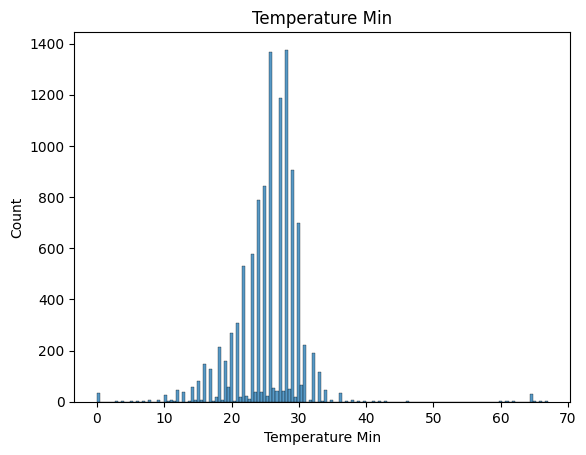

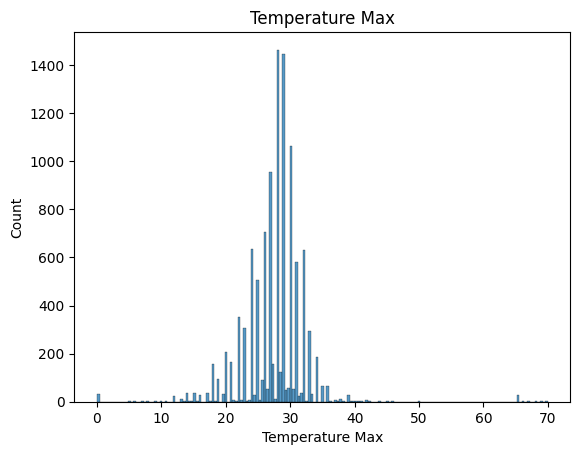

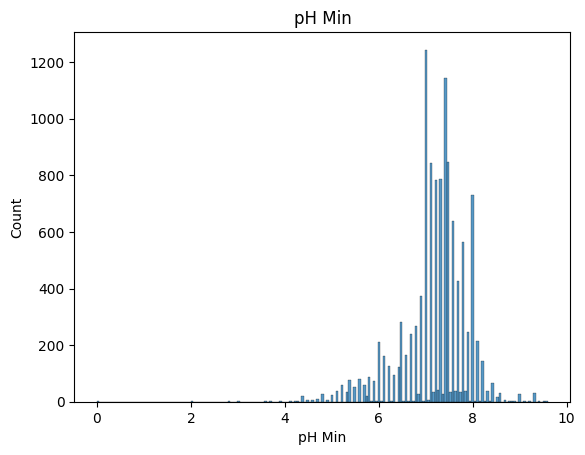

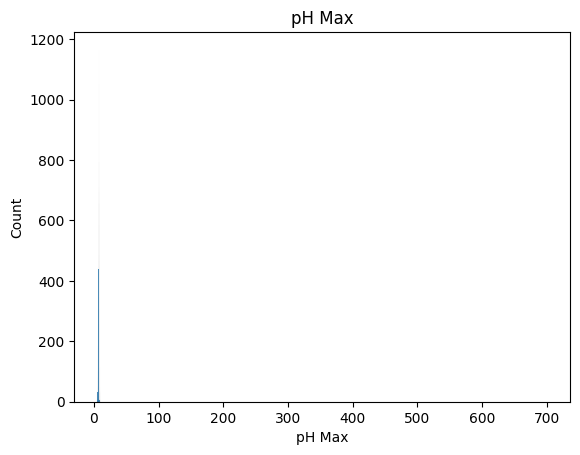

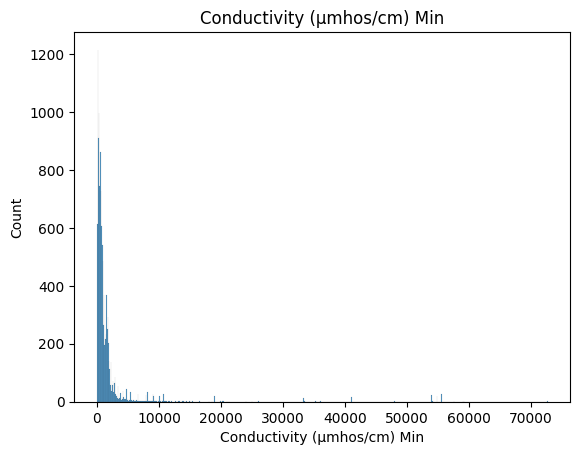

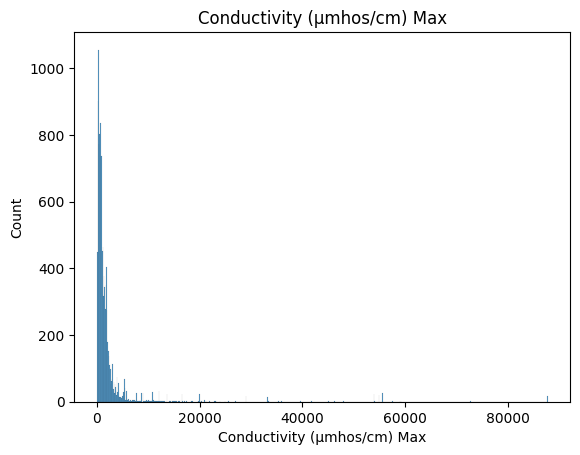

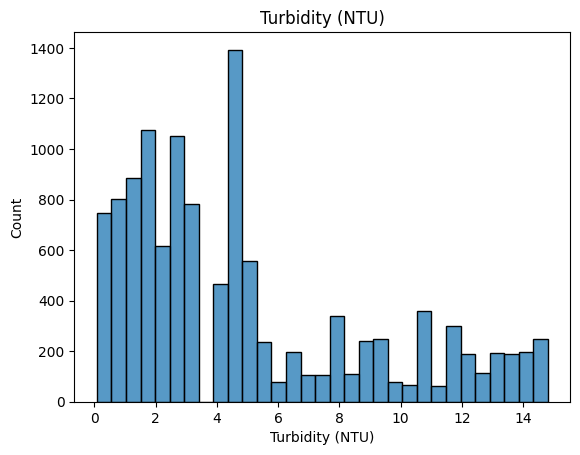

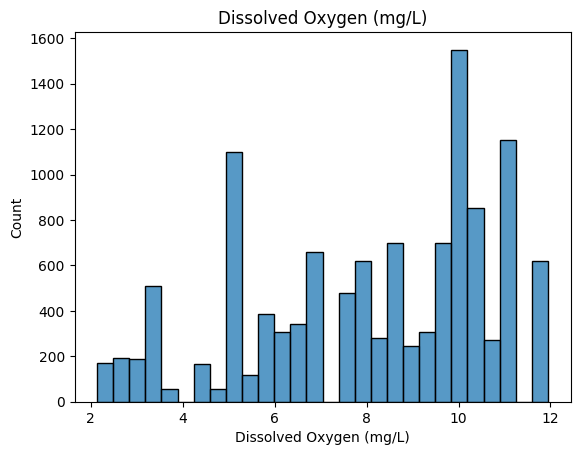

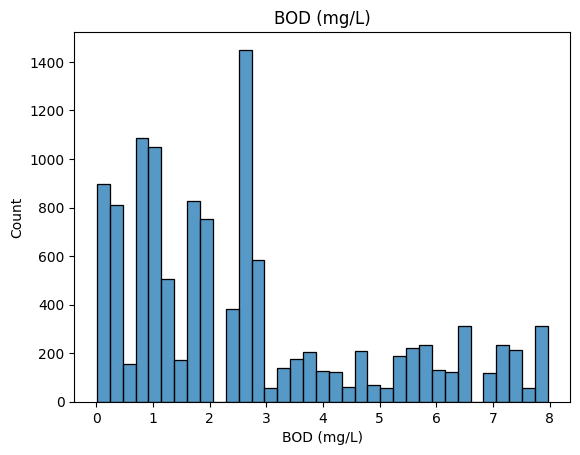

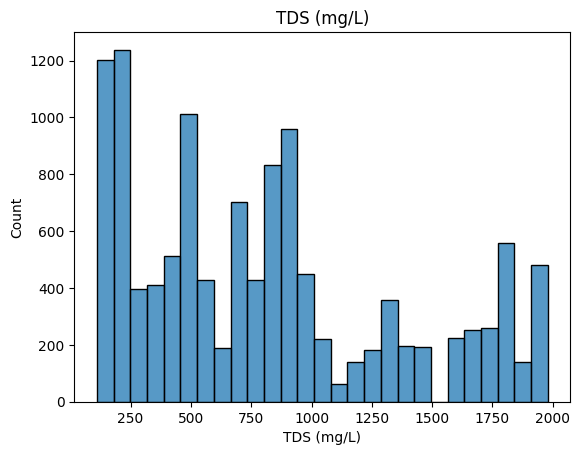

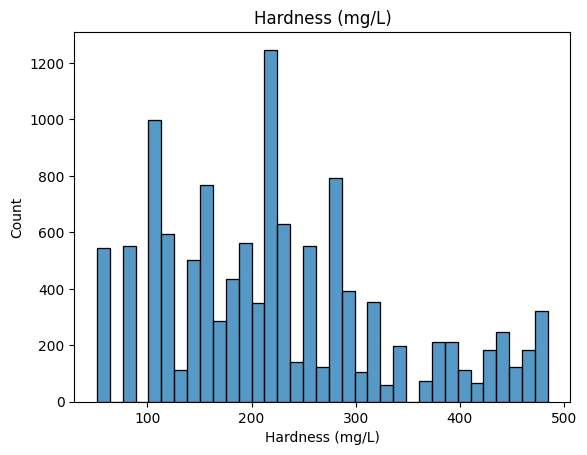

In [262]:
#histograms to understand the distribution
for i in selected_data.columns:
  sns.histplot(data=Dataset,x=i)
  plt.title(i)
  plt.show()


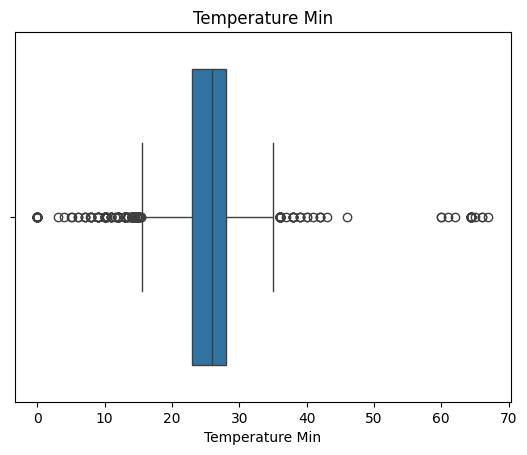

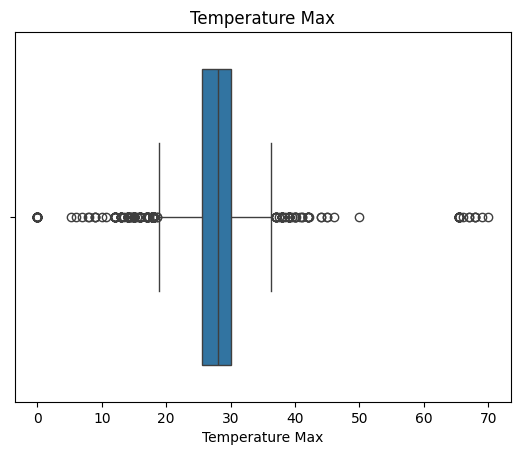

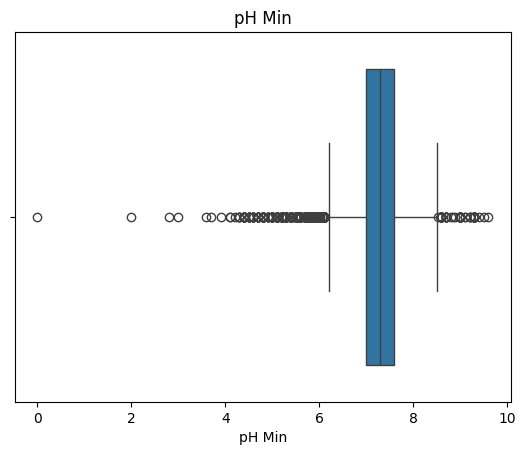

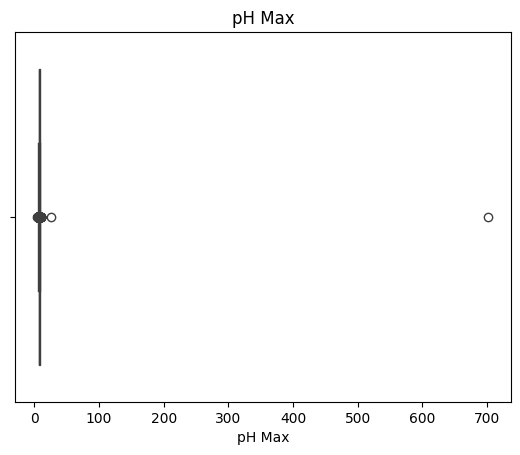

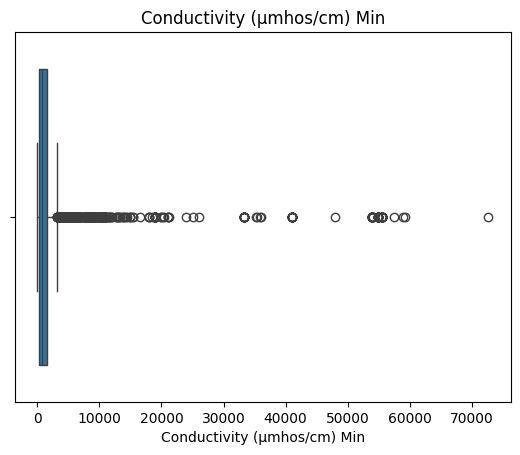

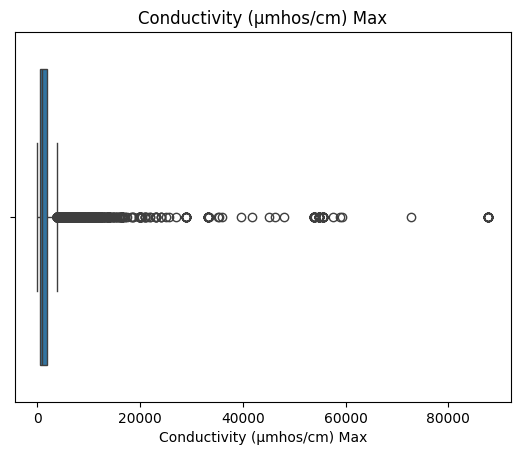

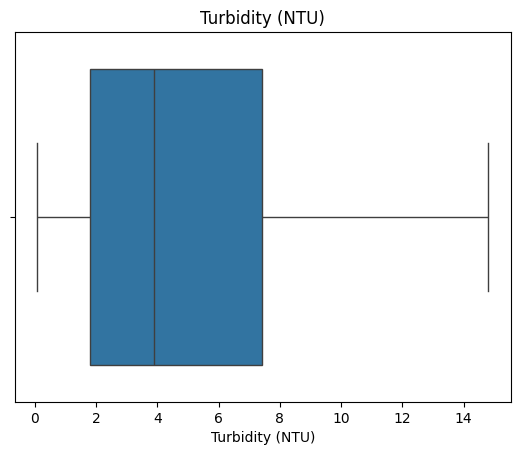

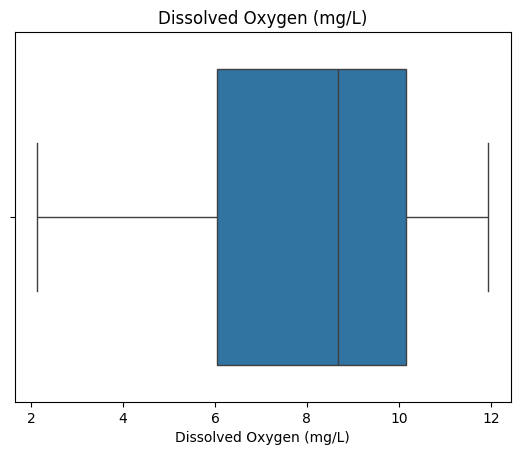

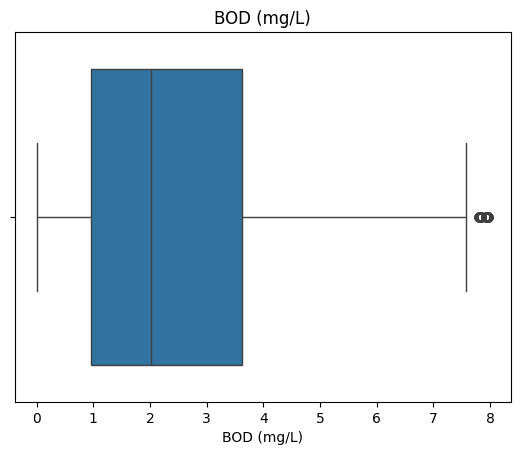

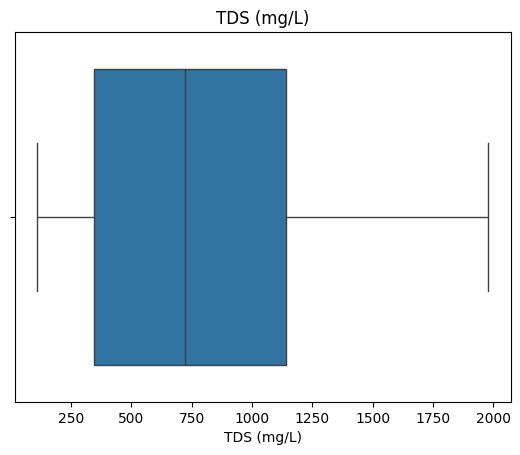

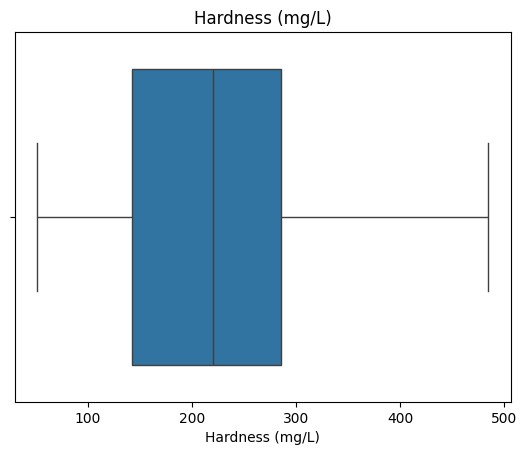

In [263]:
#Boxplot to identify Outliers
for i in selected_data.columns:
  sns.boxplot(data=Dataset,x=i)
  plt.title(i)
  plt.show()

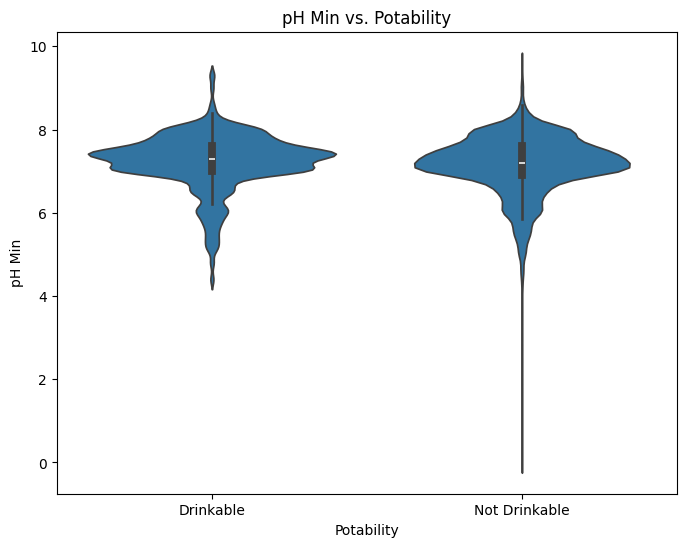

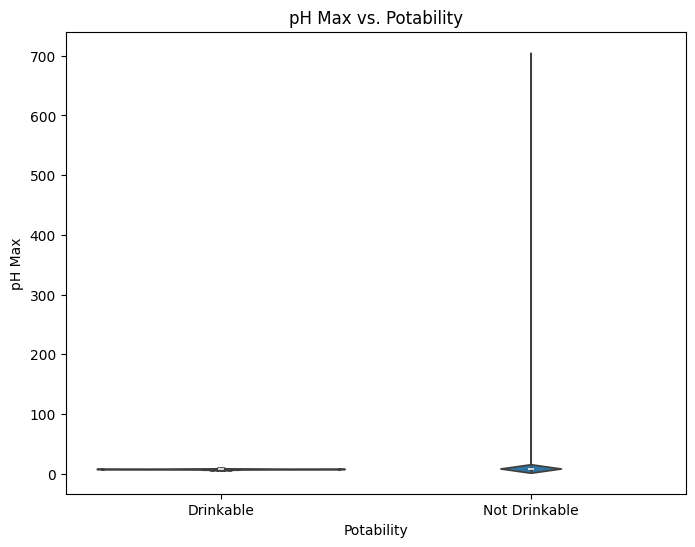

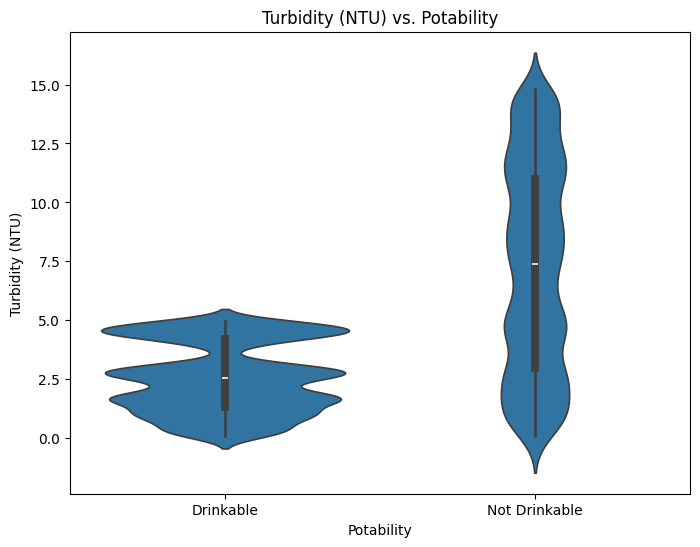

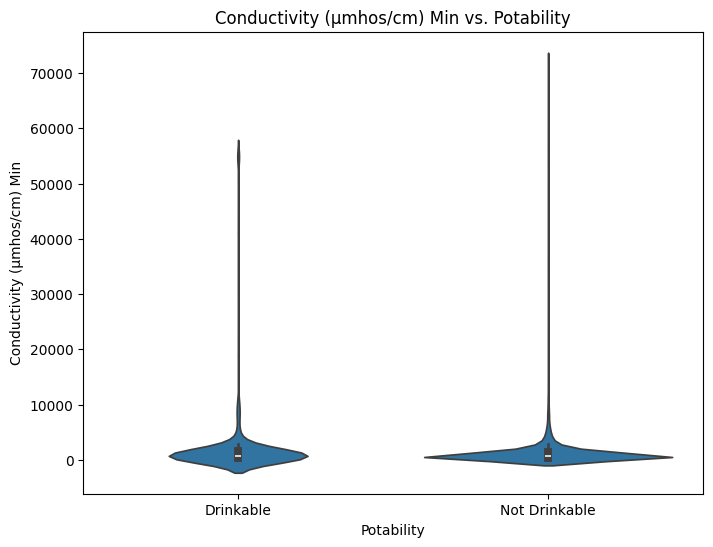

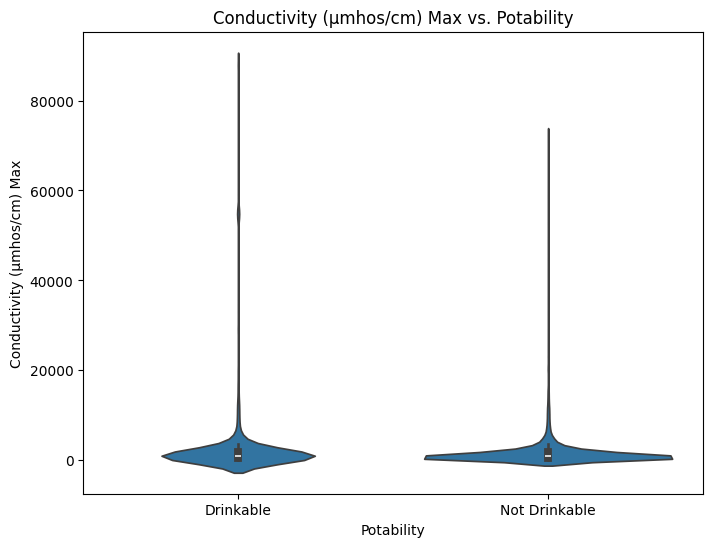

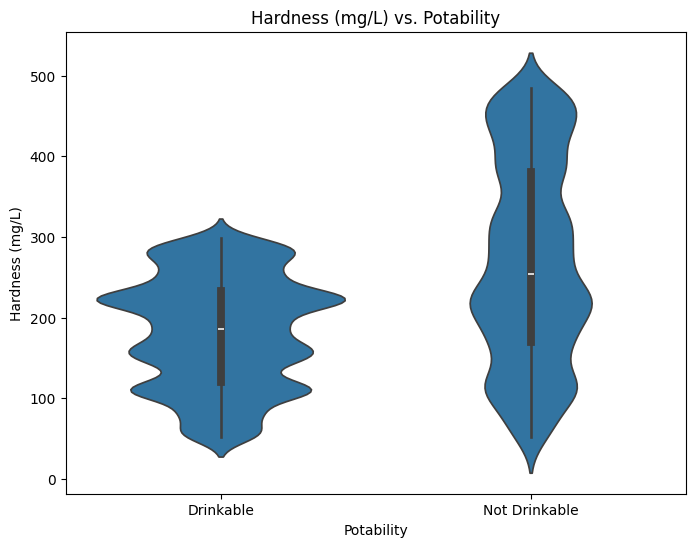

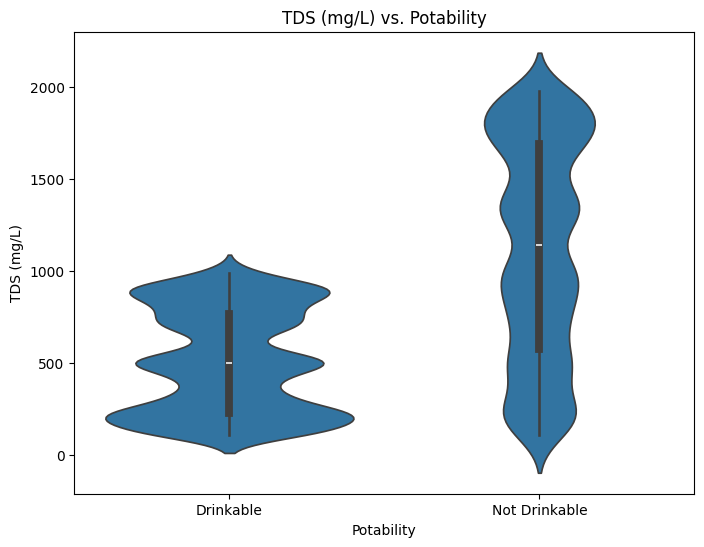

In [264]:
# prompt: give a best plotting technique which compares each attribute to potability other than histplot and boxplot

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Dataset' and 'selected_data' are defined as in the previous code.

# Create a list of attributes to compare with potability
attributes = ['pH Min', 'pH Max', 'Turbidity (NTU)', 'Conductivity (µmhos/cm) Min',
              'Conductivity (µmhos/cm) Max', 'Hardness (mg/L)', 'TDS (mg/L)']

# Plotting using violinplots
for attribute in attributes:
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.violinplot(x='Potability', y=attribute, data=Dataset)
    plt.title(f'{attribute} vs. Potability')
    plt.xlabel('Potability')
    plt.ylabel(attribute)
    plt.show()

In [265]:
#correlation with heatmap to interpret the relation and multicolliniarity
corr =selected_data.corr()
corr

,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L)
Temperature Min,1.000000,0.830448,0.123377,0.013942,0.089000,0.073487,0.009061,0.009368,-0.000166,-0.003191,0.011672
Temperature Max,0.830448,1.000000,0.081674,0.015695,0.065954,0.072768,-0.012094,0.019866,-0.010335,0.006327,-0.003233
pH Min,0.123377,0.081674,1.000000,0.070006,0.159941,0.163665,0.007405,0.000337,-0.010276,-0.017512,-0.001897
pH Max,0.013942,0.015695,0.070006,1.000000,0.013070,0.014312,0.002247,-0.019785,0.013073,-0.002856,0.000642
Conductivity (µmhos/cm) Min,0.089000,0.065954,0.159941,0.013070,1.000000,0.909731,-0.003163,0.027068,-0.015542,-0.014877,-0.009364
Conductivity (µmhos/cm) Max,0.073487,0.072768,0.163665,0.014312,0.909731,1.000000,0.001569,0.029100,-0.012572,-0.015586,-0.009966
Turbidity (NTU),0.009061,-0.012094,0.007405,0.002247,-0.003163,0.001569,1.000000,0.009649,-0.004839,0.009203,0.016756
Dissolved Oxygen (mg/L),0.009368,0.019866,0.000337,-0.019785,0.027068,0.029100,0.009649,1.000000,-0.006262,-0.000074,0.024323
BOD (mg/L),-0.000166,-0.010335,-0.010276,0.013073,-0.015542,-0.012572,-0.004839,-0.006262,1.000000,0.011733,0.000750
TDS (mg/L),-0.003191,0.006327,-0.017512,-0.002856,-0.014877,-0.015586,0.009203,-0.000074,0.011733,1.000000,-0.004154


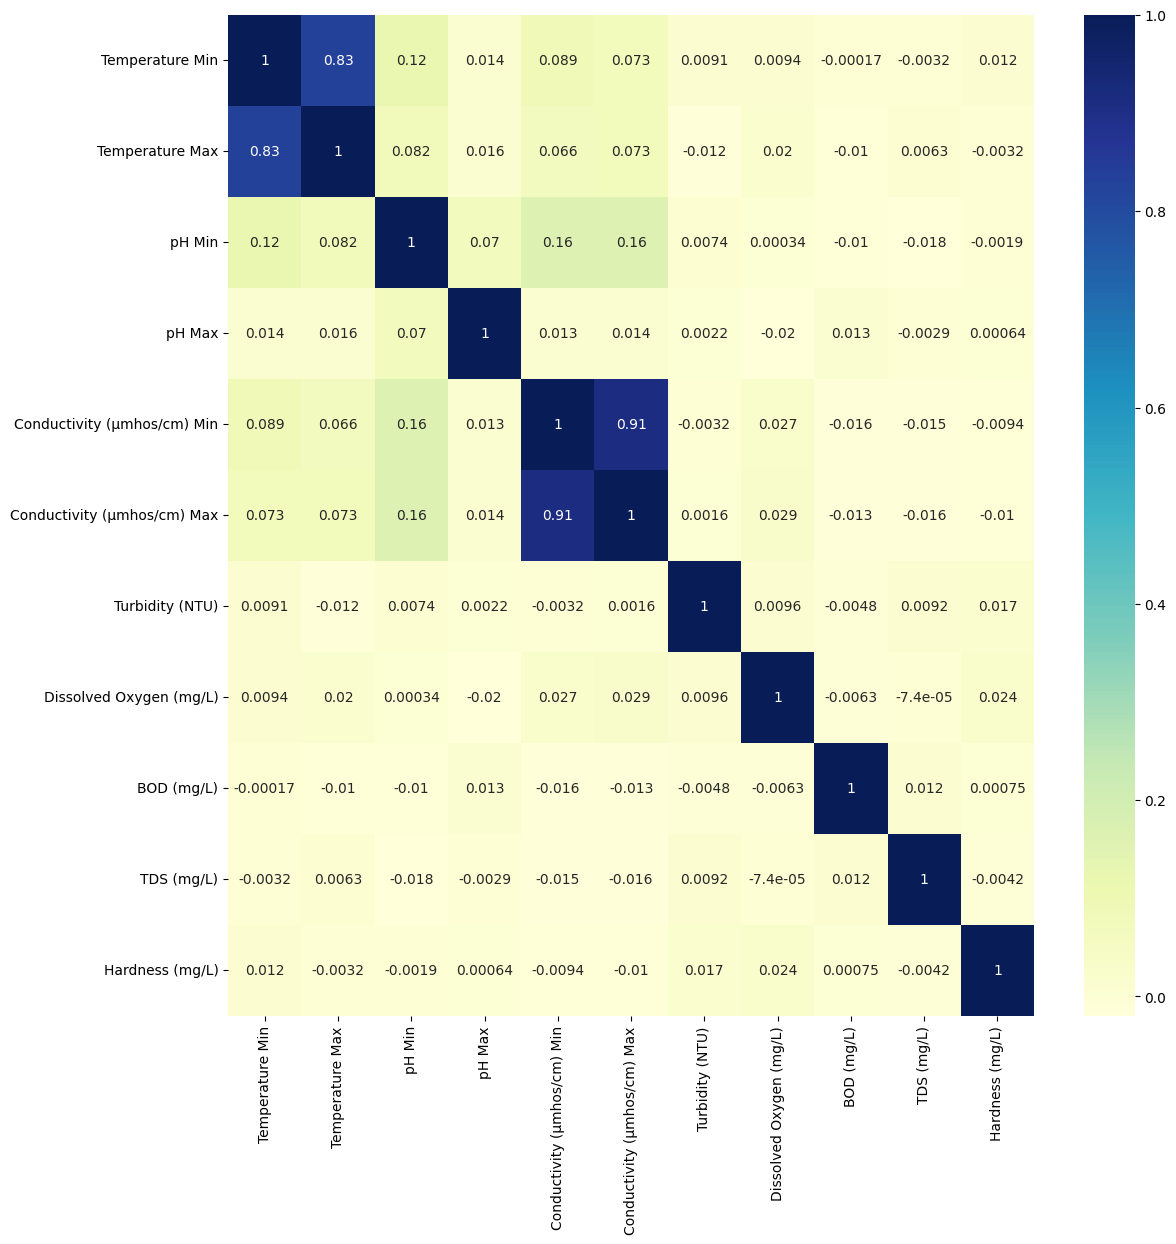

In [266]:
plt.figure(figsize=(13,13))
sns.heatmap(corr, annot=True, cmap="YlGnBu") # Change 'YlGnBu' to your desired colormap
plt.show()

##MISSING VALUE TREATMENT

In [267]:
Dataset.isnull().sum()

,0
Unnamed: 0,0
Station Code,91
Station Name,64
STATE,90
Temperature Min,1096
Temperature Max,1096
pH Min,210
pH Max,210
Conductivity (µmhos/cm) Min,324
Conductivity (µmhos/cm) Max,324


In [268]:
columns_to_impute = ['Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)', 'TDS (mg/L)', 'Hardness (mg/L)']

# Apply median imputation for each column
for column in columns_to_impute:
    median_value = Dataset[column].median()
    Dataset[column]=Dataset[column].fillna(median_value)

In [269]:
Dataset.isnull().sum()

,0
Unnamed: 0,0
Station Code,91
Station Name,64
STATE,90
Temperature Min,1096
Temperature Max,1096
pH Min,210
pH Max,210
Conductivity (µmhos/cm) Min,324
Conductivity (µmhos/cm) Max,324


In [270]:
import pandas as pd
from sklearn.impute import KNNImputer

knn_impute = ['Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
                     'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max']

# Create a KNNImputer instance (using k=5 as a common choice)
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation only to the specified columns
Dataset[knn_impute] = imputer.fit_transform(Dataset[knn_impute])


In [271]:
Dataset.isnull().sum()

,0
Unnamed: 0,0
Station Code,91
Station Name,64
STATE,90
Temperature Min,0
Temperature Max,0
pH Min,0
pH Max,0
Conductivity (µmhos/cm) Min,0
Conductivity (µmhos/cm) Max,0


In [272]:
Dataset = Dataset.dropna(subset=['Station Code'])
Dataset.isnull().sum()

,0
Unnamed: 0,0
Station Code,0
Station Name,0
STATE,0
Temperature Min,0
Temperature Max,0
pH Min,0
pH Max,0
Conductivity (µmhos/cm) Min,0
Conductivity (µmhos/cm) Max,0


In [273]:
Dataset

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability
0,0,15.0,"WELL AT KUYYURA, A.P.",ANDHRA PRADESH,23.00,28.00,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,Drinkable
1,1,16.0,WELL AT TADAVAI A.P.,ANDHRA PRADESH,27.00,28.00,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,Not Drinkable
2,2,26.0,"WELL AT VIJAYWADA, A.P.",ANDHRA PRADESH,26.00,32.00,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,Not Drinkable
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",ANDHRA PRADESH,26.00,27.00,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,Not Drinkable
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",ANDHRA PRADESH,25.00,30.00,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,Not Drinkable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12089,129,3148.0,JAMALPUR HAND PUMP WATER POLICE STATION\nJAMALPUR,BIHAR,29.00,29.00,8.60,8.60,1190.0,1190.0,2018,0.082832,7.923014,2.026023,510.372024,189.606583,Drinkable
12090,512,1454.0,"WELL AT KALAPET,\nPONDI. UNIVER.\nADMN. BLOCK",PONDICHERRY,30.00,32.00,7.30,7.40,165.0,175.0,2016,2.980735,10.398204,0.849003,480.030896,118.252913,Drinkable
12091,302,1879.0,NALAGARH INDUSTRIAL AREA,HIMACHAL PRADESH,23.00,23.00,7.60,8.30,967.0,994.0,2018,0.381287,6.423665,2.624557,227.428538,149.004490,Drinkable
12092,262,2638.0,HAND PUMP AT\nCHINTPURNI\nTEMPLE/ TOWN,HIMACHAL PRADESH,26.14,27.08,7.00,6.60,671.0,671.0,2015,1.793914,8.666171,0.157806,177.685485,85.108415,Drinkable


##Handling Outliers

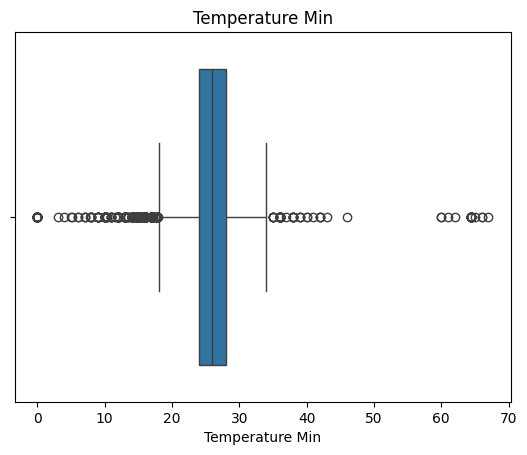

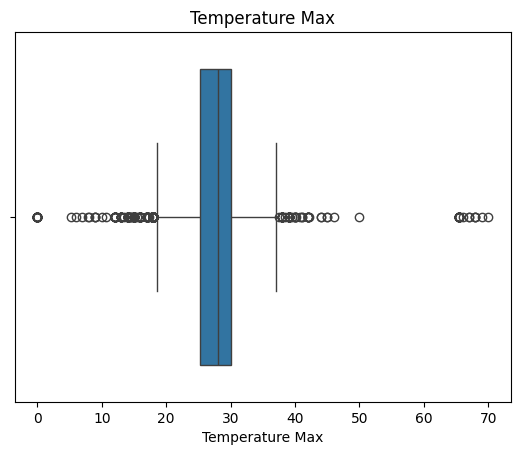

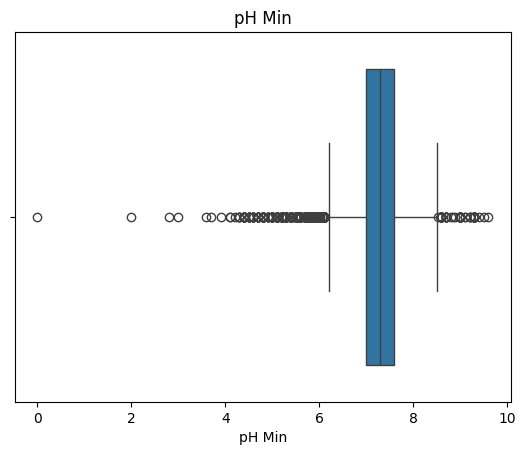

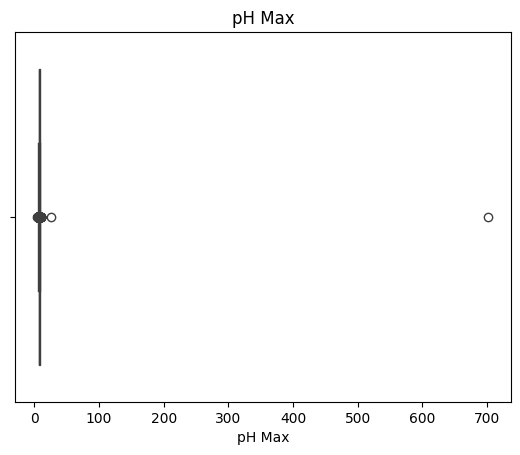

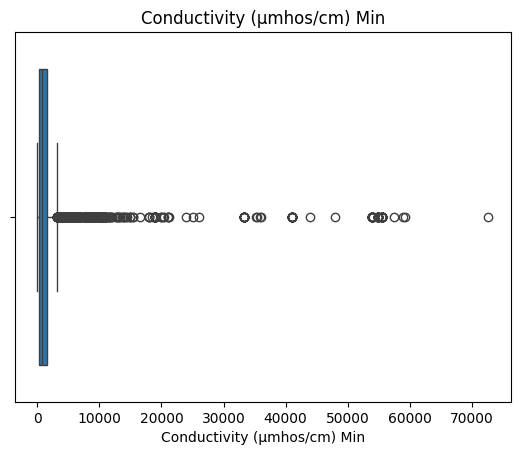

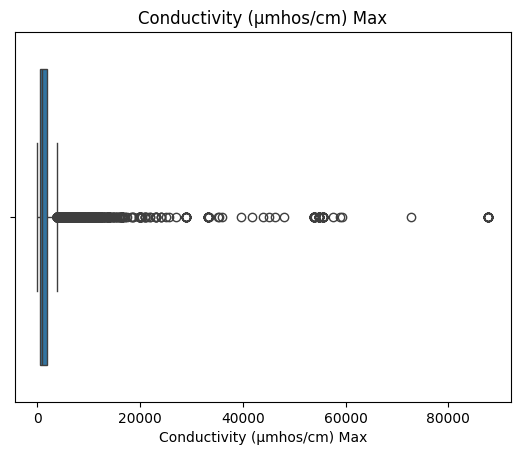

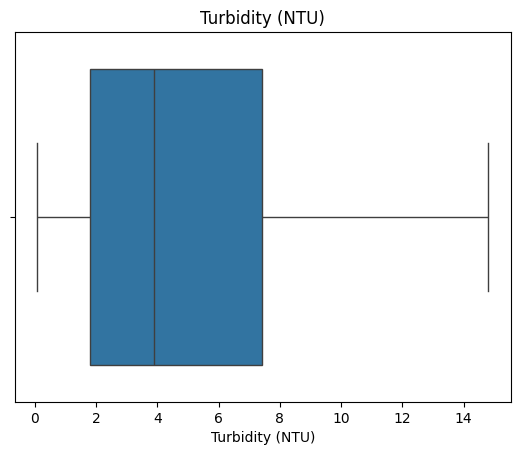

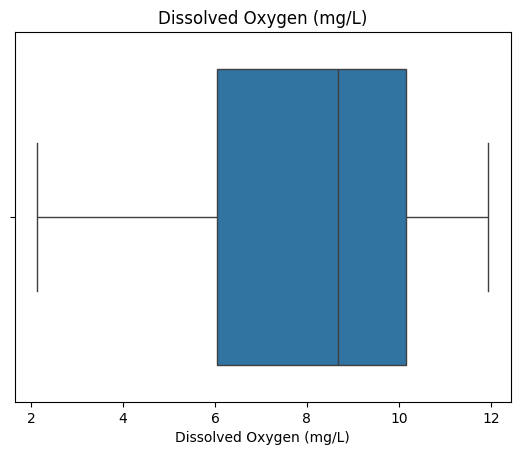

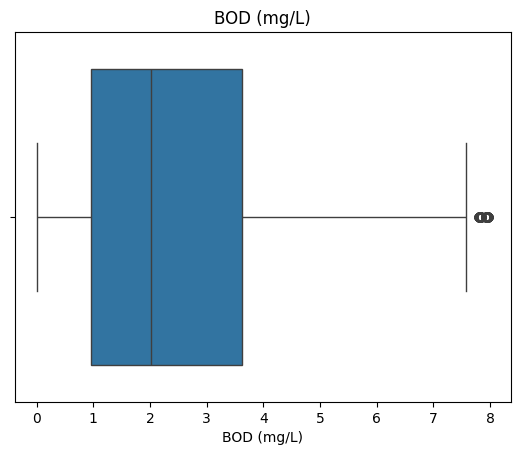

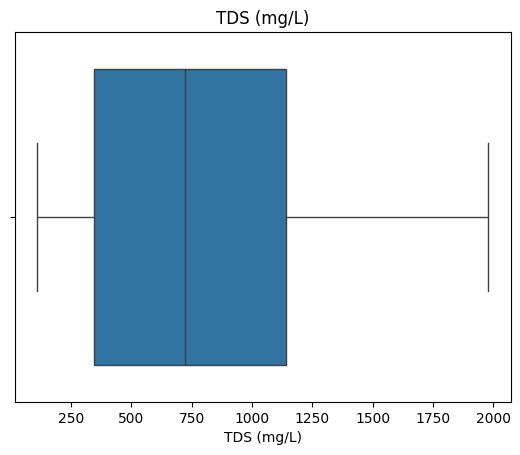

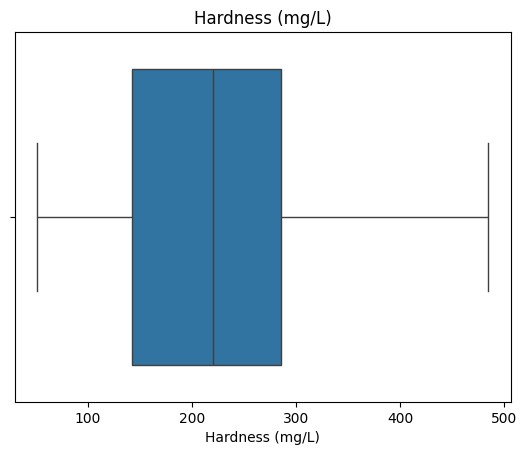

In [274]:
for i in selected_data.columns:
  sns.boxplot(data=Dataset,x=i)
  plt.title(i)
  plt.show()

In [275]:
def wisker(col):
  q1,q3 = np.percentile(col,[25,75])
  iqr = q3-q1
  lower_bound = q1 - (1.5*iqr)
  upper_bound = q3 + (1.5*iqr)
  return lower_bound,upper_bound

In [276]:
Dataset.columns

Index(['Unnamed: 0', 'Station Code', 'Station Name', 'STATE',
       'Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
       'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max', 'Year',
       'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)',
       'TDS (mg/L)', 'Hardness (mg/L)', 'Potability'],
      dtype='object')

In [277]:


for i in ['Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
          'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max']:
    lower_bound, upper_bound = wisker(Dataset[i])

    # Use .loc to limit values to within the whisker range
    Dataset.loc[Dataset[i] > upper_bound, i] = upper_bound
    Dataset.loc[Dataset[i] < lower_bound, i] = lower_bound


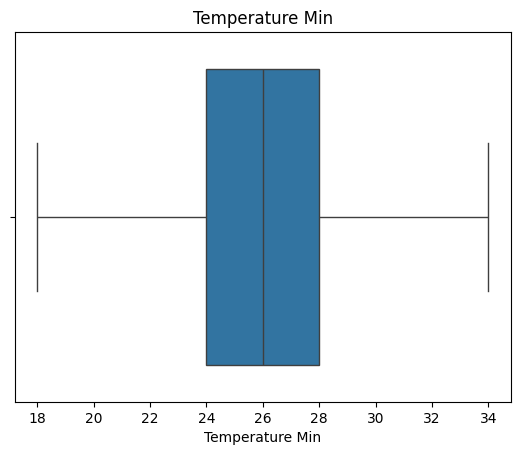

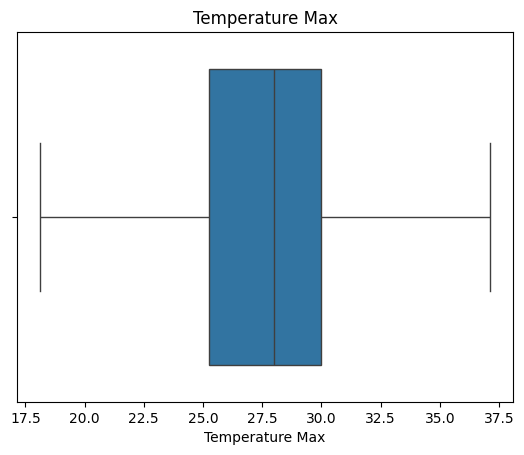

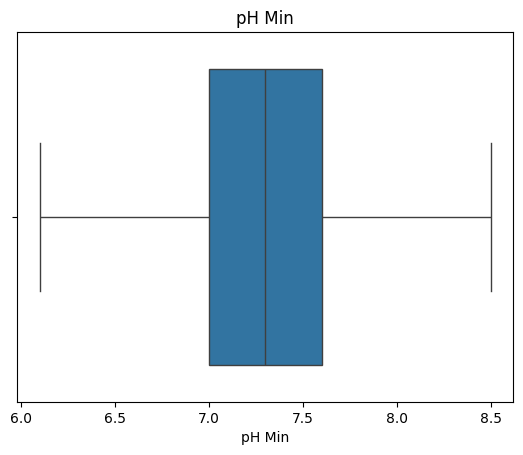

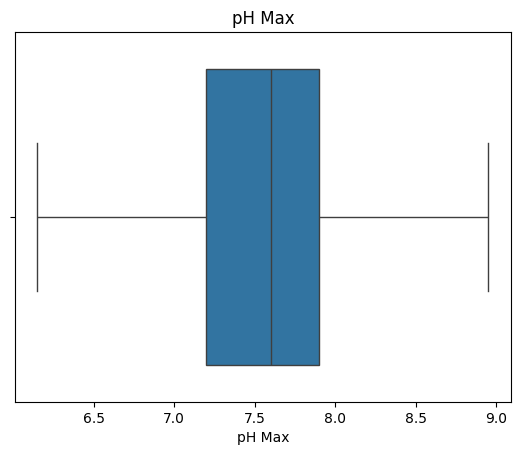

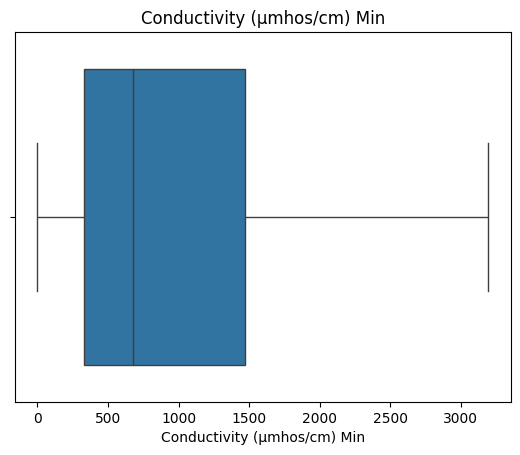

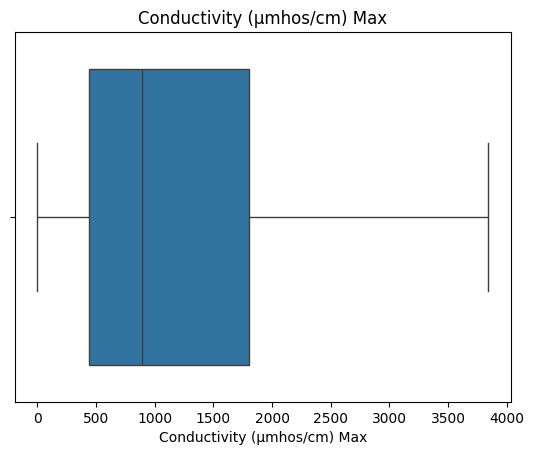

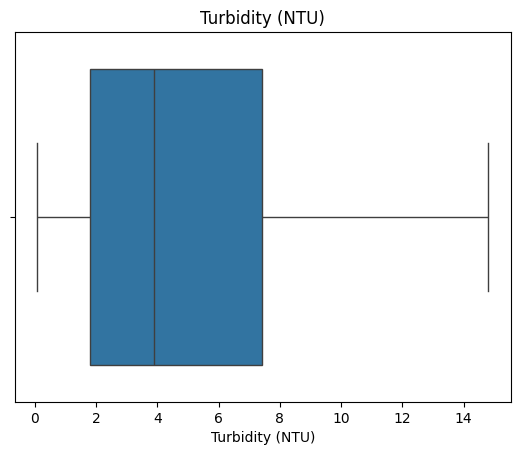

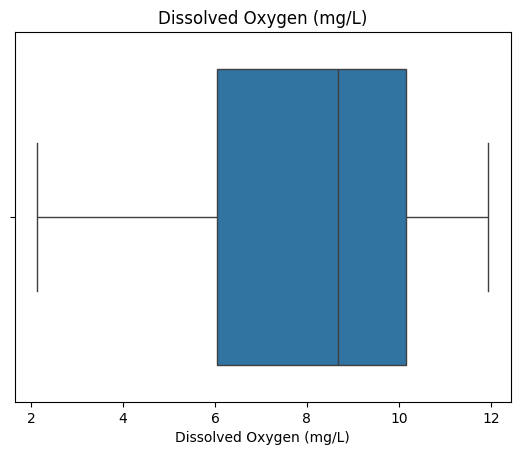

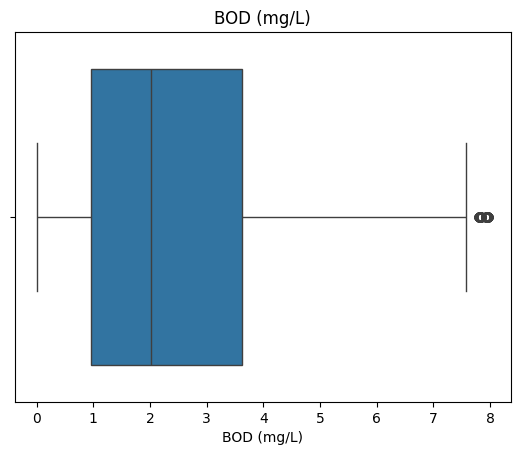

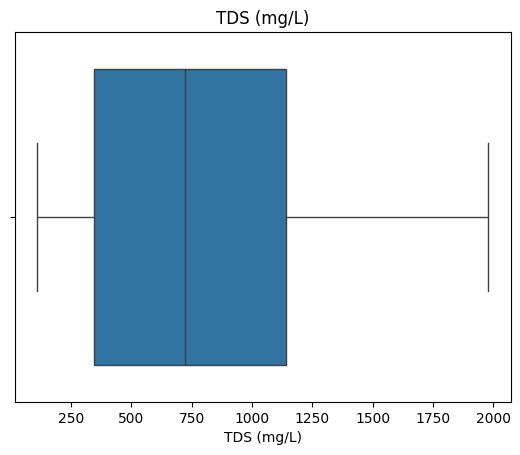

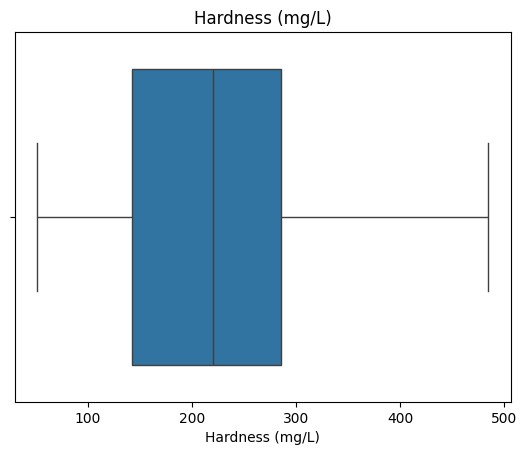

In [278]:
for i in selected_data.columns:
  sns.boxplot(data=Dataset,x=i)
  plt.title(i)
  plt.show()

##Added columns like Temperature Mean,pH Mean and Conductivity Mean

In [279]:
Dataset = Dataset.assign(
       pH_Mean=(Dataset['pH Min'] + Dataset['pH Max']) / 2,
       Conductivity_Mean=(Dataset['Conductivity (µmhos/cm) Min'] + Dataset['Conductivity (µmhos/cm) Max']) / 2,
       Temperature_Mean=(Dataset['Temperature Min'] + Dataset['Temperature Max']) / 2
   )


In [280]:
Dataset

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability,pH_Mean,Conductivity_Mean,Temperature_Mean
0,0,15.0,"WELL AT KUYYURA, A.P.",ANDHRA PRADESH,23.00,28.00,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,Drinkable,7.335,210.5,25.50
1,1,16.0,WELL AT TADAVAI A.P.,ANDHRA PRADESH,27.00,28.00,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,Not Drinkable,7.465,892.0,27.50
2,2,26.0,"WELL AT VIJAYWADA, A.P.",ANDHRA PRADESH,26.00,32.00,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,Not Drinkable,7.290,1631.0,29.00
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",ANDHRA PRADESH,26.00,27.00,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,Not Drinkable,8.310,1544.0,26.50
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",ANDHRA PRADESH,25.00,30.00,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,Not Drinkable,6.955,1514.5,27.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12089,129,3148.0,JAMALPUR HAND PUMP WATER POLICE STATION\nJAMALPUR,BIHAR,29.00,29.00,8.50,8.60,1190.0,1190.0,2018,0.082832,7.923014,2.026023,510.372024,189.606583,Drinkable,8.550,1190.0,29.00
12090,512,1454.0,"WELL AT KALAPET,\nPONDI. UNIVER.\nADMN. BLOCK",PONDICHERRY,30.00,32.00,7.30,7.40,165.0,175.0,2016,2.980735,10.398204,0.849003,480.030896,118.252913,Drinkable,7.350,170.0,31.00
12091,302,1879.0,NALAGARH INDUSTRIAL AREA,HIMACHAL PRADESH,23.00,23.00,7.60,8.30,967.0,994.0,2018,0.381287,6.423665,2.624557,227.428538,149.004490,Drinkable,7.950,980.5,23.00
12092,262,2638.0,HAND PUMP AT\nCHINTPURNI\nTEMPLE/ TOWN,HIMACHAL PRADESH,26.14,27.08,7.00,6.60,671.0,671.0,2015,1.793914,8.666171,0.157806,177.685485,85.108415,Drinkable,6.800,671.0,26.61


#DATA VISUALIZATION


# Assuming your data is loaded into a DataFrame called 'df'
# Replace this with your actual data loading code
# df = pd.read_csv('your_dataset.csv')

<Figure size 1200x600 with 0 Axes>

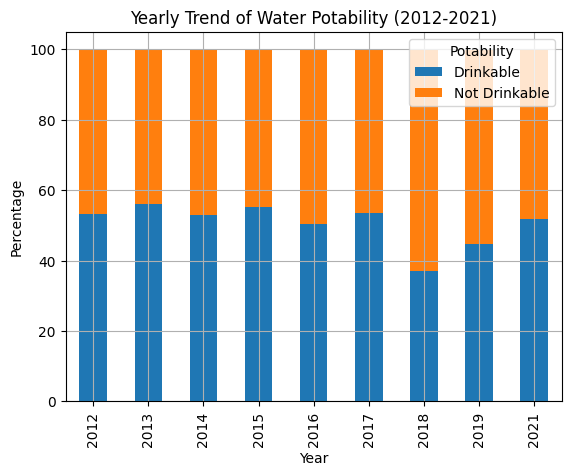

In [281]:




    # 1. Yearly Trend of Water Potability
    plt.figure(figsize=(12, 6))
    yearly_potability = Dataset.groupby(['Year', 'Potability']).size().unstack()
    yearly_potability_pct = yearly_potability.div(yearly_potability.sum(axis=1), axis=0) * 100
    yearly_potability_pct.plot(kind='bar', stacked=True)
    plt.title('Yearly Trend of Water Potability (2012-2021)')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.legend(title='Potability')
    plt.grid(True)
    plt.show()




**Year-wise Quality Trend:**


1.Reveals long-term trends in water quality
2.Shows effectiveness of water management policies
3.Identifies periods of quality improvement or deterioration
4.Helps in future water quality predictions





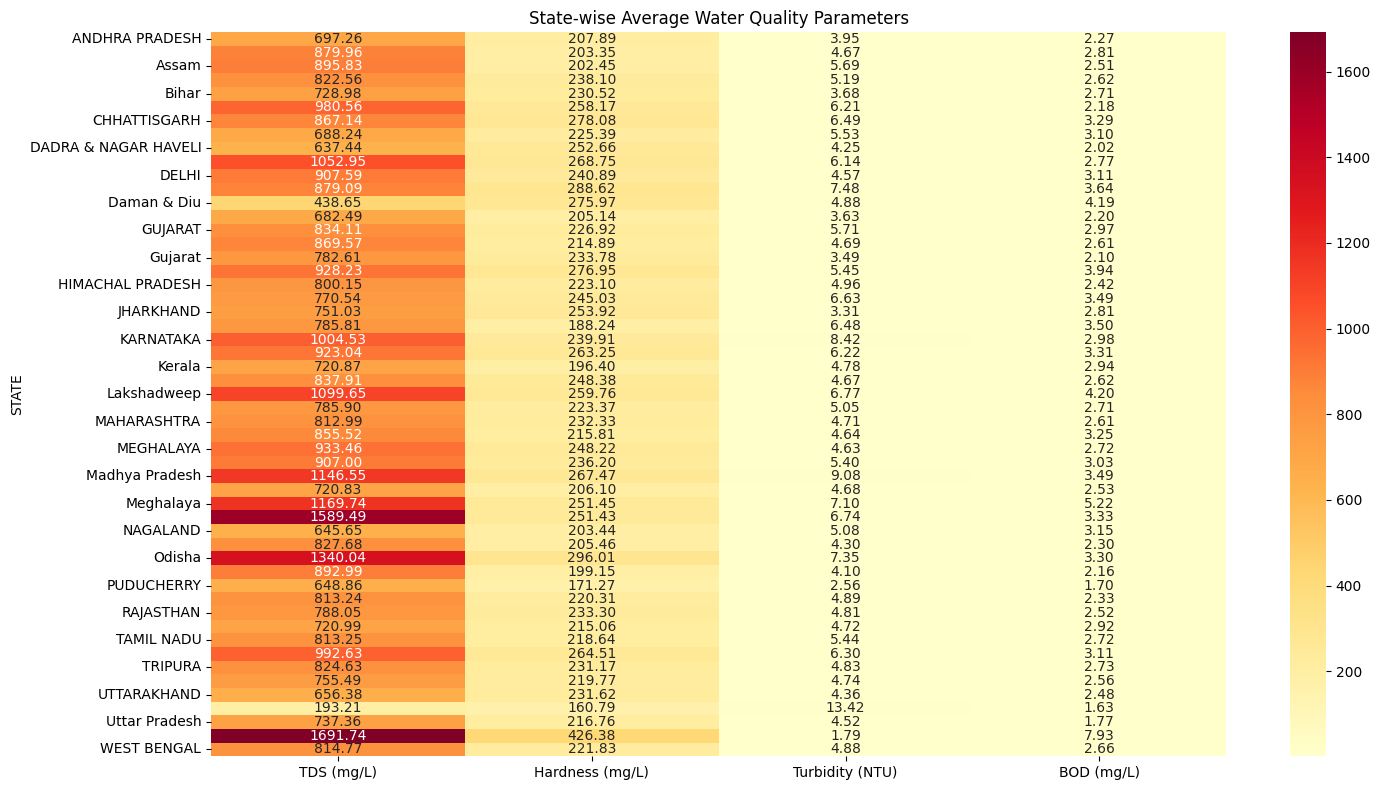

In [282]:
 # 2. State-wise Water Quality Heatmap
plt.figure(figsize=(15, 8)) # Removed extra indentation here
state_params = Dataset.groupby('STATE')[['TDS (mg/L)', 'Hardness (mg/L)', 'Turbidity (NTU)', 'BOD (mg/L)']].mean()
sns.heatmap(state_params, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('State-wise Average Water Quality Parameters')
plt.tight_layout()
plt.show()


***State-wise Quality Comparison:***


1.Compares overall water quality across states
2.Identifies states needing immediate intervention
3.Shows regional patterns in water quality
4.Useful for resource allocation

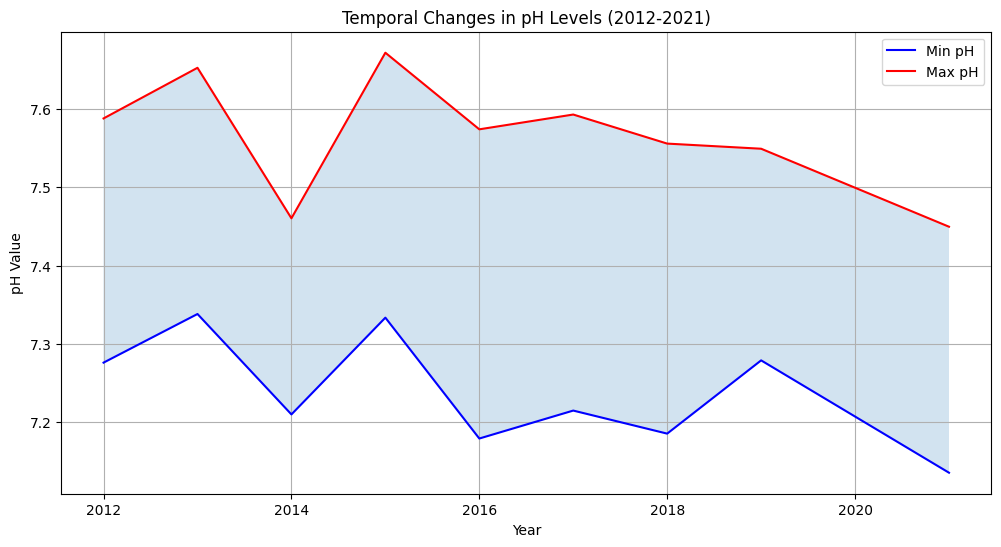

In [283]:
    # 3. Temporal Changes in pH Levels
    plt.figure(figsize=(12, 6))
    yearly_ph = Dataset.groupby('Year')[['pH Min', 'pH Max']].mean()
    plt.plot(yearly_ph.index, yearly_ph['pH Min'], 'b-', label='Min pH')
    plt.plot(yearly_ph.index, yearly_ph['pH Max'], 'r-', label='Max pH')
    plt.fill_between(yearly_ph.index, yearly_ph['pH Min'], yearly_ph['pH Max'], alpha=0.2)
    plt.title('Temporal Changes in pH Levels (2012-2021)')
    plt.xlabel('Year')
    plt.ylabel('pH Value')
    plt.legend()
    plt.grid(True)
    plt.show()

***pH Range Analysis:***


1.Shows state-wise variations in pH levels
2.Identifies states with concerning pH ranges
3.Helps in targeted pH treatment planning
4.Useful for ecological impact assessment

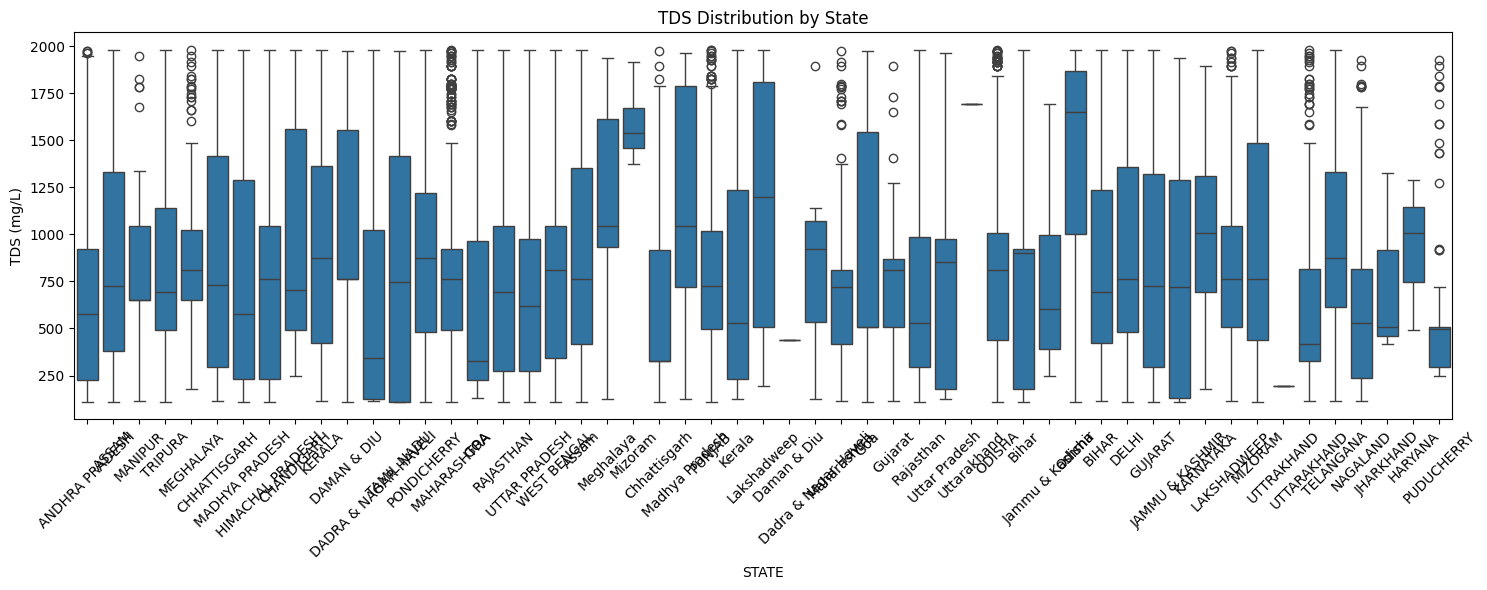

In [284]:
    # 4. Box Plot of TDS Distribution by State
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='STATE', y='TDS (mg/L)', data=Dataset)
    plt.xticks(rotation=45)
    plt.title('TDS Distribution by State')
    plt.tight_layout()
    plt.show()


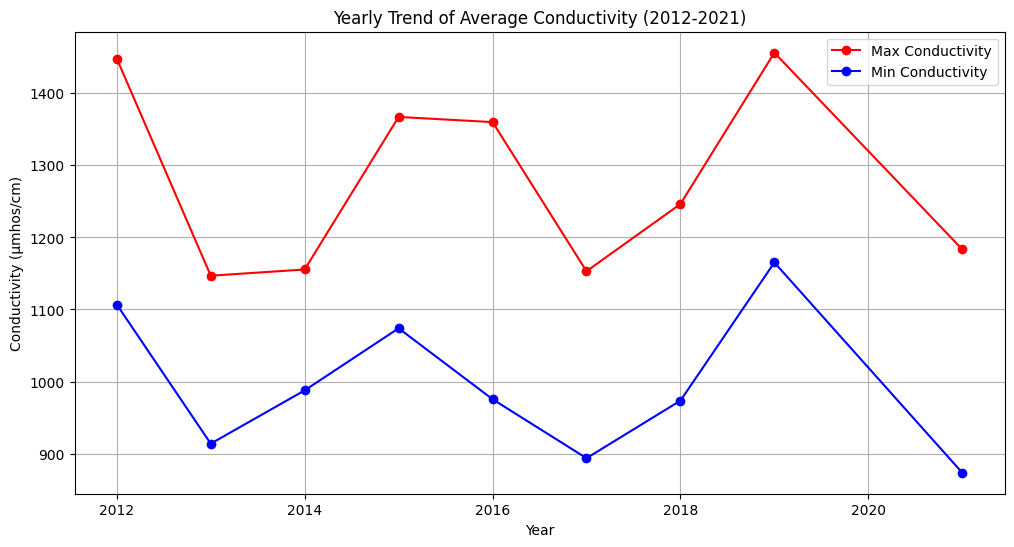

In [285]:
    # 5. Yearly Trend of Average Conductivity
    plt.figure(figsize=(12, 6))
    yearly_conductivity = Dataset.groupby('Year')[['Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max']].mean()
    plt.plot(yearly_conductivity.index, yearly_conductivity['Conductivity (µmhos/cm) Max'],
             'ro-', label='Max Conductivity')
    plt.plot(yearly_conductivity.index, yearly_conductivity['Conductivity (µmhos/cm) Min'],
             'bo-', label='Min Conductivity')
    plt.title('Yearly Trend of Average Conductivity (2012-2021)')
    plt.xlabel('Year')
    plt.ylabel('Conductivity (μmhos/cm)')
    plt.legend()
    plt.grid(True)
    plt.show()

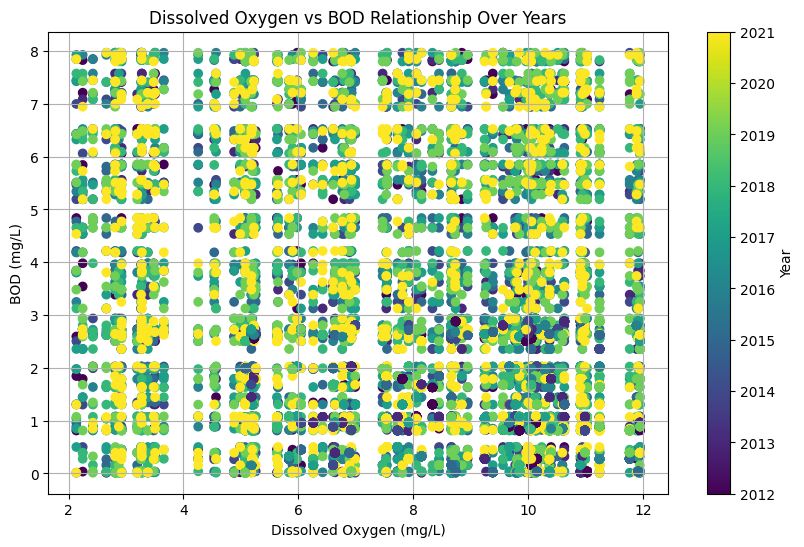

In [286]:
    # 6. Dissolved Oxygen vs BOD Scatter Plot with Year Color Coding
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(Dataset['Dissolved Oxygen (mg/L)'], Dataset['BOD (mg/L)'],
                         c=Dataset['Year'], cmap='viridis')
    plt.colorbar(scatter, label='Year')
    plt.xlabel('Dissolved Oxygen (mg/L)')
    plt.ylabel('BOD (mg/L)')
    plt.title('Dissolved Oxygen vs BOD Relationship Over Years')
    plt.grid(True)
    plt.show()

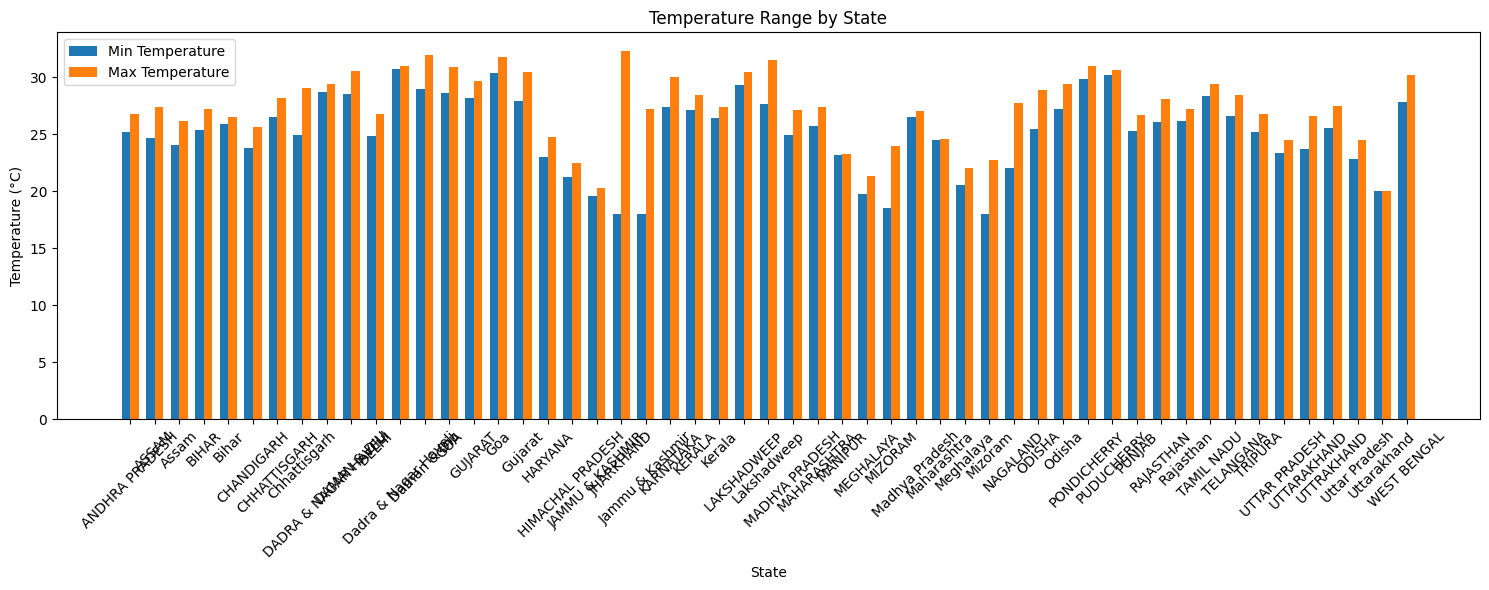

In [287]:
    # 7. Temperature Range by State and Season
    plt.figure(figsize=(15, 6))
    state_temp = Dataset.groupby('STATE')[['Temperature Min', 'Temperature Max']].mean()
    x = np.arange(len(state_temp.index))
    width = 0.35
    plt.bar(x - width/2, state_temp['Temperature Min'], width, label='Min Temperature')
    plt.bar(x + width/2, state_temp['Temperature Max'], width, label='Max Temperature')
    plt.xlabel('State')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature Range by State')
    plt.xticks(x, state_temp.index, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

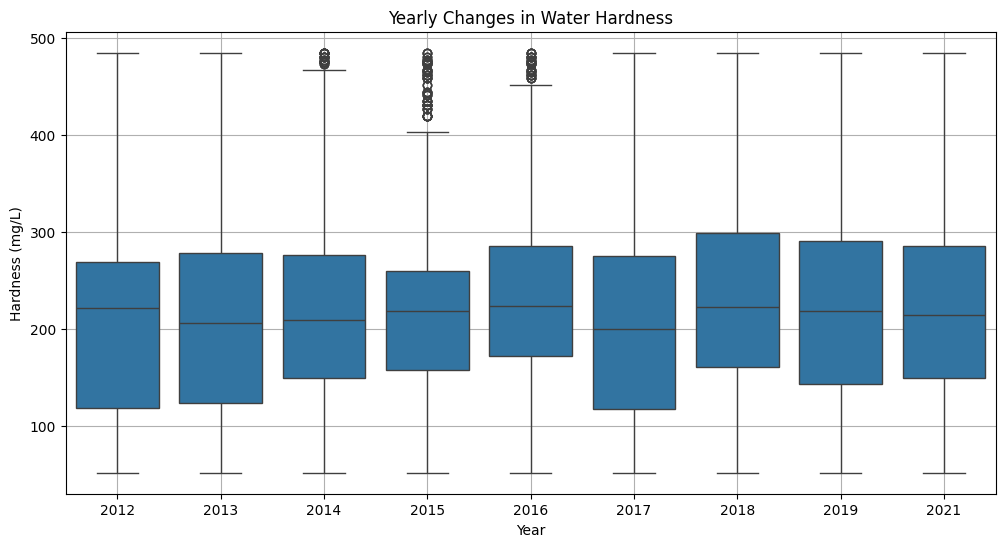

In [288]:
    # 8. Yearly Changes in Water Hardness
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Year', y='Hardness (mg/L)', data=Dataset)
    plt.title('Yearly Changes in Water Hardness')
    plt.xlabel('Year')
    plt.ylabel('Hardness (mg/L)')
    plt.grid(True)
    plt.show()

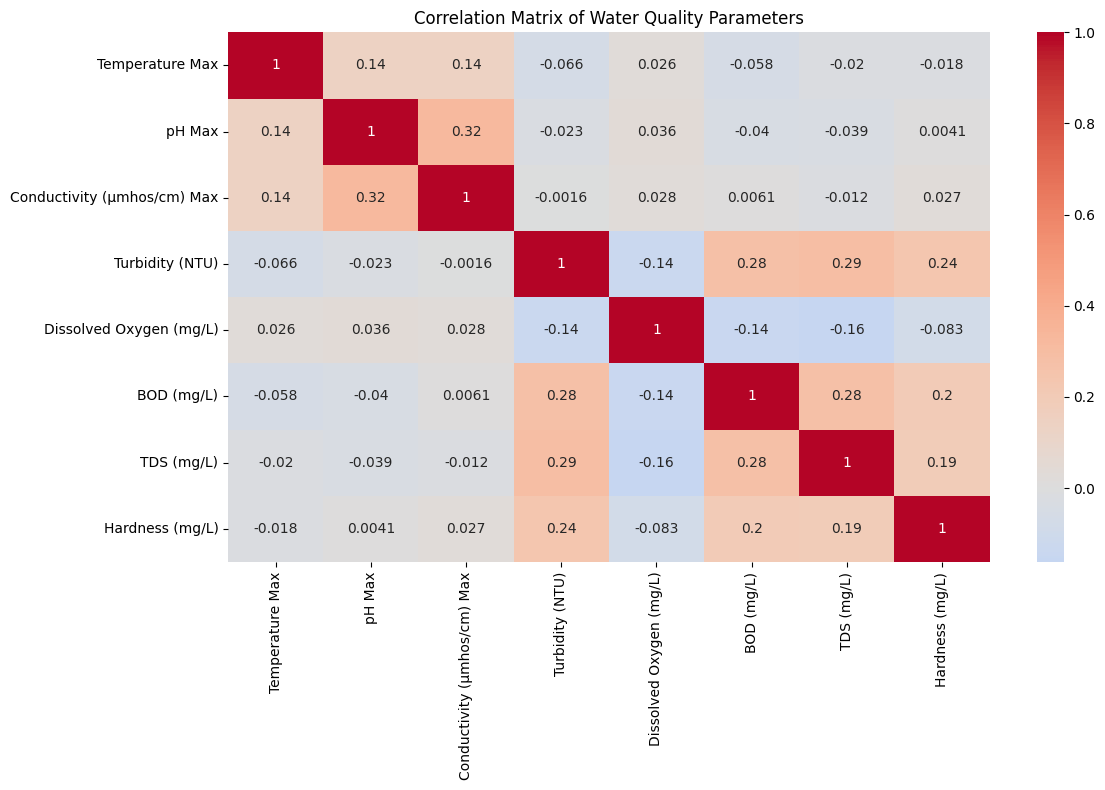

In [289]:
# 9. Correlation Matrix Over Time
plt.figure(figsize=(12, 8))
numeric_cols = ['Temperature Max', 'pH Max', 'Conductivity (µmhos/cm) Max',
               'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)', 'TDS (mg/L)', 'Hardness (mg/L)']
# Replacing 'df' with 'Dataset' to access the DataFrame containing the data
correlation = Dataset[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Water Quality Parameters')
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

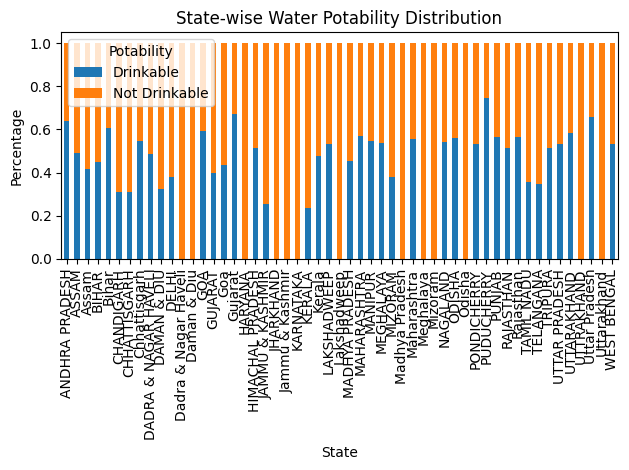

In [290]:
    # 10. State-wise Potability Analysis
    plt.figure(figsize=(15, 6))
    state_potability = Dataset.groupby('STATE')['Potability'].value_counts(normalize=True).unstack()
    state_potability.plot(kind='bar', stacked=True)
    plt.title('State-wise Water Potability Distribution')
    plt.xlabel('State')
    plt.ylabel('Percentage')
    plt.legend(title='Potability')
    plt.tight_layout()
    plt.show()

#ENCODING

#One-hot encode the 'State' column

In [291]:
Dataset['STATE'] = Dataset['STATE'].str.replace('Uttrakhand', 'Uttarakhand', case=False)

In [292]:
Dataset['STATE'] = Dataset['STATE'].str.title().str.strip()

In [293]:
# Dataset = pd.get_dummies(Dataset, columns=["STATE"], drop_first=True)
# Dataset

In [294]:
Dataset.columns

Index(['Unnamed: 0', 'Station Code', 'Station Name', 'STATE',
       'Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
       'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max', 'Year',
       'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)',
       'TDS (mg/L)', 'Hardness (mg/L)', 'Potability', 'pH_Mean',
       'Conductivity_Mean', 'Temperature_Mean'],
      dtype='object')

#Encoding Potability

In [295]:
Dataset['Potability'] = Dataset['Potability'].map({'Drinkable': 1, 'Not Drinkable': 0})
Dataset

,Unnamed: 0,Station Code,Station Name,STATE,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),Potability,pH_Mean,Conductivity_Mean,Temperature_Mean
0,0,15.0,"WELL AT KUYYURA, A.P.",Andhra Pradesh,23.00,28.00,6.82,7.85,195.0,226.0,2012,4.070235,10.134345,0.962008,578.810775,104.950680,1,7.335,210.5,25.50
1,1,16.0,WELL AT TADAVAI A.P.,Andhra Pradesh,27.00,28.00,7.21,7.72,663.0,1121.0,2012,11.564508,10.595564,7.927889,529.066337,205.746813,0,7.465,892.0,27.50
2,2,26.0,"WELL AT VIJAYWADA, A.P.",Andhra Pradesh,26.00,32.00,7.19,7.39,1601.0,1661.0,2012,14.543769,10.297229,1.070086,920.225147,217.964732,0,7.290,1631.0,29.00
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",Andhra Pradesh,26.00,27.00,7.82,8.80,1420.0,1668.0,2012,11.564508,10.297229,6.486625,1198.784496,182.125474,0,8.310,1544.0,26.50
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",Andhra Pradesh,25.00,30.00,6.80,7.11,1454.0,1575.0,2012,10.979909,3.262711,6.434438,1043.741646,123.066151,0,6.955,1514.5,27.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12089,129,3148.0,JAMALPUR HAND PUMP WATER POLICE STATION\nJAMALPUR,Bihar,29.00,29.00,8.50,8.60,1190.0,1190.0,2018,0.082832,7.923014,2.026023,510.372024,189.606583,1,8.550,1190.0,29.00
12090,512,1454.0,"WELL AT KALAPET,\nPONDI. UNIVER.\nADMN. BLOCK",Pondicherry,30.00,32.00,7.30,7.40,165.0,175.0,2016,2.980735,10.398204,0.849003,480.030896,118.252913,1,7.350,170.0,31.00
12091,302,1879.0,NALAGARH INDUSTRIAL AREA,Himachal Pradesh,23.00,23.00,7.60,8.30,967.0,994.0,2018,0.381287,6.423665,2.624557,227.428538,149.004490,1,7.950,980.5,23.00
12092,262,2638.0,HAND PUMP AT\nCHINTPURNI\nTEMPLE/ TOWN,Himachal Pradesh,26.14,27.08,7.00,6.60,671.0,671.0,2015,1.793914,8.666171,0.157806,177.685485,85.108415,1,6.800,671.0,26.61


#Normalization

In [296]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for normalization, excluding identifiers or binary flags
numerical_columns = [
    'Temperature Min', 'Temperature Max', 'pH Min', 'pH Max',
    'Conductivity (µmhos/cm) Min', 'Conductivity (µmhos/cm) Max',
    'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'BOD (mg/L)', 'TDS (mg/L)', 'Hardness (mg/L)',
    'pH_Mean', 'Conductivity_Mean', 'Temperature_Mean'
]

# Initialize MinMaxScaler and normalize
scaler = MinMaxScaler()
Dataset[numerical_columns] = scaler.fit_transform(Dataset[numerical_columns])

# Confirm normalization by displaying the summary statistics
Dataset[numerical_columns].describe()


,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Turbidity (NTU),Dissolved Oxygen (mg/L),BOD (mg/L),TDS (mg/L),Hardness (mg/L),pH_Mean,Conductivity_Mean,Temperature_Mean
count,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000
mean,0.476712,0.492604,0.471858,0.503680,0.310049,0.332258,0.324791,0.610825,0.328438,0.374075,0.401510,0.488993,0.322177,0.485347
std,0.225774,0.195135,0.235012,0.205603,0.276445,0.284168,0.272917,0.262666,0.273581,0.292454,0.251278,0.205902,0.273896,0.198858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375000,0.375000,0.375000,0.375000,0.102363,0.113973,0.116238,0.398645,0.119121,0.124984,0.210605,0.375000,0.115098,0.368151
50%,0.500000,0.519958,0.500000,0.517857,0.212866,0.232110,0.258067,0.665596,0.252888,0.327688,0.389800,0.509615,0.227069,0.510845
75%,0.625000,0.625000,0.625000,0.625000,0.461418,0.468384,0.497545,0.817127,0.454048,0.550472,0.540380,0.644231,0.457549,0.625000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [297]:
Dataset.isnull().sum()

,0
Unnamed: 0,0
Station Code,0
Station Name,0
STATE,0
Temperature Min,0
Temperature Max,0
pH Min,0
pH Max,0
Conductivity (µmhos/cm) Min,0
Conductivity (µmhos/cm) Max,0


##ML MODEL IMPLEMENTATION FOR POTABILITY

1)MODEL 1 - LOGISTIC REGRESSION

In [298]:
# Import necessary libraries
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data into features (X) and target (y)
X = Dataset.drop(columns=['Potability','Station Code', 'Station Name','Year','STATE'])
y = Dataset['Potability']

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
logistic_reg_model = LogisticRegression(max_iter=1000)

# Train the model
logistic_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_reg_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)



In [299]:
# prompt: print accuracy percent

print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_rep)

Accuracy: 93.34%
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1216
           1       0.90      0.97      0.94      1185

    accuracy                           0.93      2401
   macro avg       0.94      0.93      0.93      2401
weighted avg       0.94      0.93      0.93      2401



2)MODEL 2 - DECISION TREES

In [300]:
# prompt: IMplement decision trees on above split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)  # You can adjust hyperparameters here

# Train the model
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)




In [301]:
print(f"Decision Tree Accuracy: {accuracy_dt * 100:.2f}%")
print(classification_rep_dt)

Decision Tree Accuracy: 99.79%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1216
           1       1.00      1.00      1.00      1185

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



3)MODEL 3 - RANDOM FOREST




In [302]:
# prompt: APPLY RANDOM FOREST ON ABOVE SPLIT

from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
random_forest_model = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters here

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)




In [303]:
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print(classification_rep_rf)

Random Forest Accuracy: 99.79%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1216
           1       1.00      1.00      1.00      1185

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



4)MODEL 4 - Support Vector Machine (SVM)



In [304]:
# # prompt: implement svm on above split

# from sklearn.svm import SVC

# # Initialize the SVM model
# svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel (e.g., 'rbf', 'poly')

# # Train the model
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_svm = svm_model.predict(X_test)

# # Evaluate the model
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# classification_rep_svm = classification_report(y_test, y_pred_svm)



In [305]:
# print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%")
# print(classification_rep_svm)

5)MODEL 5 - K-Nearest Neighbors (KNN)

In [306]:
# prompt: implement knn

from sklearn.neighbors import KNeighborsClassifier
# Assuming X_train, X_test, y_train, y_test are already defined from previous code

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)



In [307]:
print(f"KNN Accuracy: {accuracy_knn * 100:.2f}%")
print(classification_rep_knn)

KNN Accuracy: 92.71%
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1216
           1       0.87      1.00      0.93      1185

    accuracy                           0.93      2401
   macro avg       0.94      0.93      0.93      2401
weighted avg       0.94      0.93      0.93      2401



6)MODEL 6 - NAIVE BAYES

In [308]:
# prompt: implement naive bayes

from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the model
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = naive_bayes_model.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)



In [309]:
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")
print(classification_rep_nb)

Naive Bayes Accuracy: 96.58%
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1216
           1       0.94      0.99      0.97      1185

    accuracy                           0.97      2401
   macro avg       0.97      0.97      0.97      2401
weighted avg       0.97      0.97      0.97      2401



In [310]:
# prompt: show a table with TWO COLUMNS MODEL USED AND THEIR ACCURACY

import pandas as pd

data = {
    # 'Model Used': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Machine (SVM)', 'K-Nearest Neighbors (KNN)', 'Naive Bayes'],
    # 'Accuracy': [accuracy * 100, accuracy_dt * 100, accuracy_rf * 100, accuracy_svm * 100, accuracy_knn * 100, accuracy_nb * 100]
    'Model Used': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors (KNN)', 'Naive Bayes'],
    'Accuracy': [accuracy * 100, accuracy_dt * 100, accuracy_rf * 100, accuracy_knn * 100, accuracy_nb * 100]
}

df = pd.DataFrame(data)
df

,Model Used,Accuracy
0,Logistic Regression,93.336110
1,Decision Tree,99.791753
2,Random Forest,99.791753
3,K-Nearest Neighbors (KNN),92.711370
4,Naive Bayes,96.584756


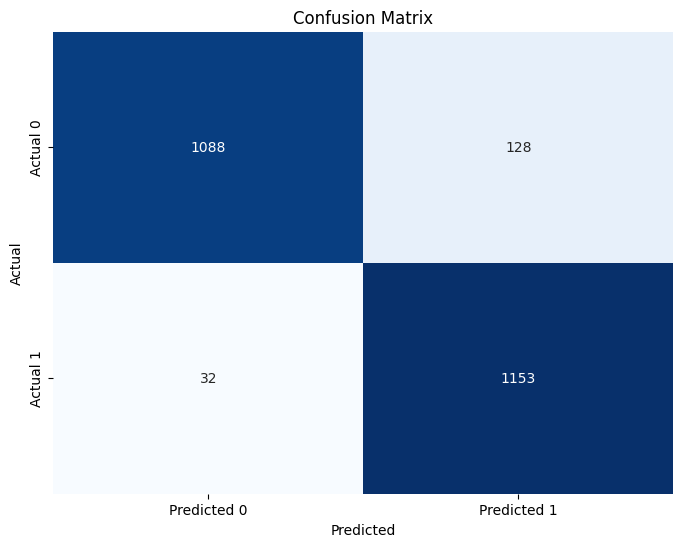

In [311]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model predictions
# Example:
# y_pred = logistic_reg_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

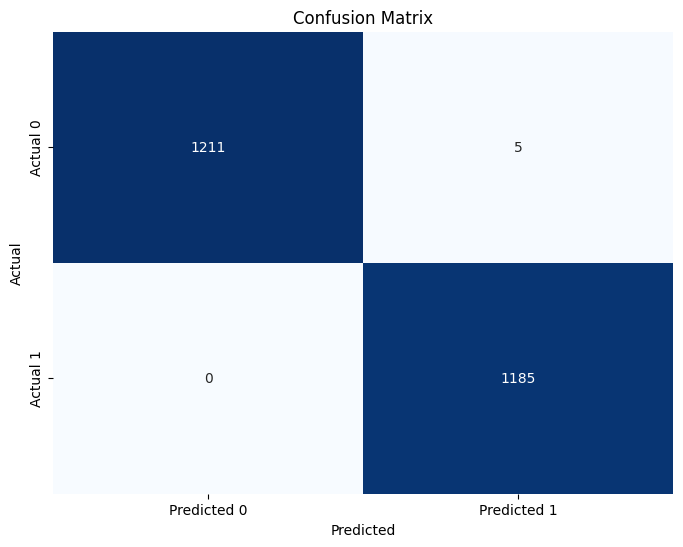

In [312]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model predictions
# Example:
# y_pred = logistic_reg_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

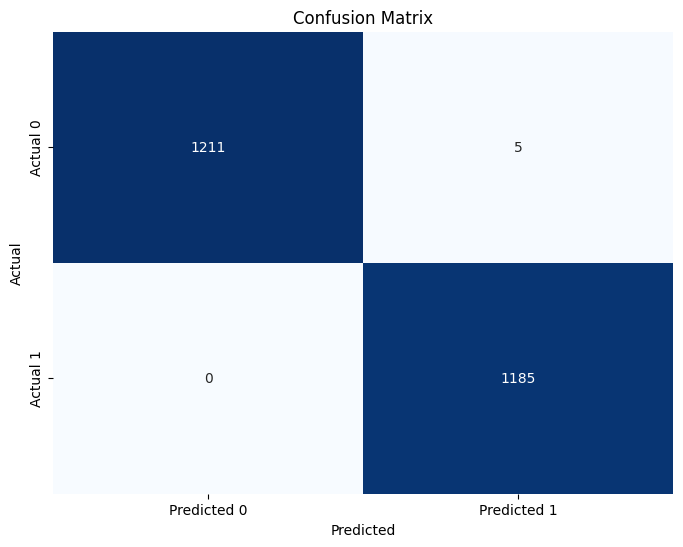

In [313]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model predictions
# Example:
# y_pred = logistic_reg_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [314]:
# # prompt: confusion matrix

# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming y_test and y_pred are already defined from your model predictions
# # Example:
# # y_pred = logistic_reg_model.predict(X_test)

# cm = confusion_matrix(y_test, y_pred_svm)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=['Predicted 0', 'Predicted 1'],
#             yticklabels=['Actual 0', 'Actual 1'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

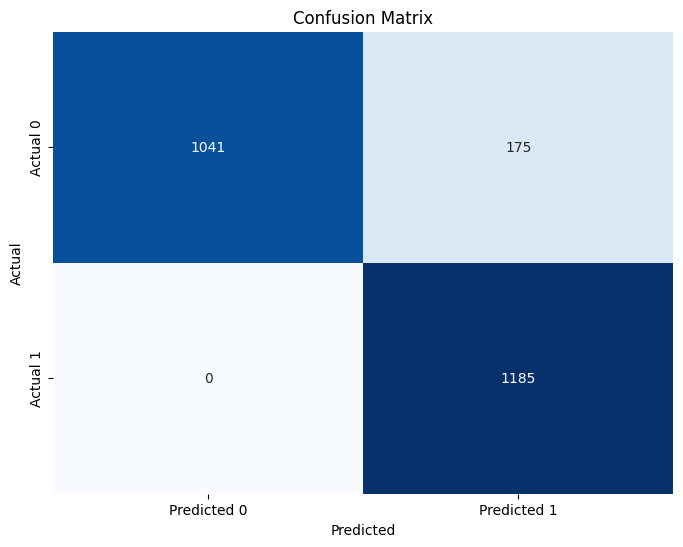

In [315]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model predictions
# Example:
# y_pred = logistic_reg_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

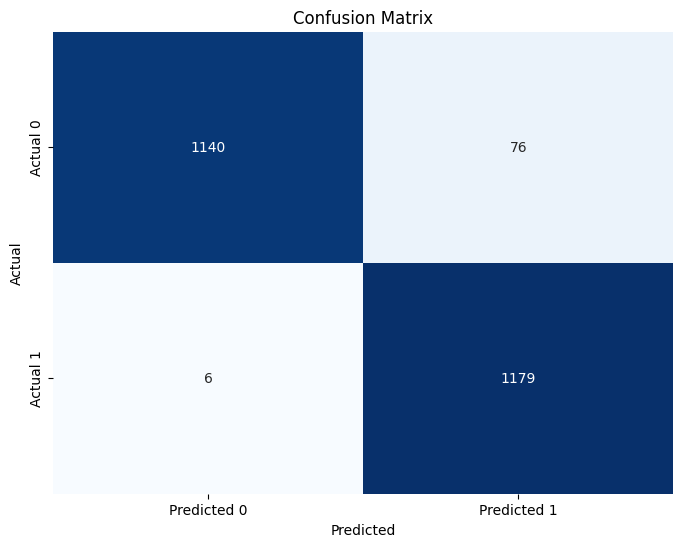

In [316]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model predictions
# Example:
# y_pred = logistic_reg_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

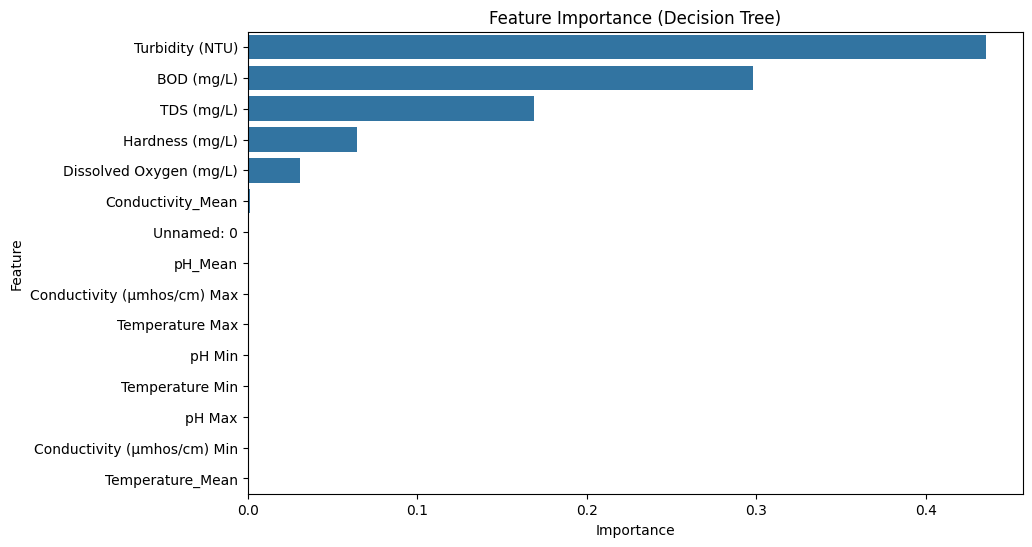

In [317]:
# prompt: feature importance for decision tree plot graph

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X and y are defined as in your previous code
# Example:
# X = Dataset.drop(columns=['Potability','Station Code', 'Station Name','Year'])
# y = Dataset['Potability']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model (if not already done)
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Get feature importances
importances = decision_tree_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)


# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [318]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Define features and target
features = ['Dissolved Oxygen (mg/L)', 'Hardness (mg/L)','TDS (mg/L)', 'BOD (mg/L)','Turbidity (NTU)']
X_train_selected = X_train[features]
X_test_selected = X_test[features]

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Verify the distribution of classes after SMOTE
print("Class distribution before SMOTE:", np.bincount(y_train))
print("Class distribution after SMOTE:", np.bincount(y_train_smote))

# Train the Decision Tree model on the balanced data
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_smote, y_train_smote)

# Make predictions on the original test set
y_pred = dt_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Class distribution before SMOTE: [4756 4846]
Class distribution after SMOTE: [4846 4846]
Accuracy: 0.9991670137442732
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1216
           1       1.00      1.00      1.00      1185

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401

Confusion Matrix:
[[1214    2]
 [   0 1185]]


In [320]:
# prompt: take user input and predict scale before predicting

import pandas as pd
# Assuming your trained model (e.g., decision_tree_model) is already loaded

# Get user input for the features
dissolved_oxygen = float(input("Enter Dissolved Oxygen (mg/L): "))
hardness = float(input("Enter Hardness (mg/L): "))
tds = float(input("Enter TDS (mg/L): "))
bod = float(input("Enter BOD (mg/L): "))
turbidity = float(input("Enter Turbidity (NTU): "))

# Create a DataFrame from the user input
user_input = pd.DataFrame({
    'Dissolved Oxygen (mg/L)': [dissolved_oxygen],
    'Hardness (mg/L)': [hardness],
    'TDS (mg/L)': [tds],
    'BOD (mg/L)': [bod],
    'Turbidity (NTU)': [turbidity]
})

# Scale the user input using the same scaler used for training data
user_input_scaled = scaler.transform(user_input)

# Make a prediction using your trained model
prediction = dt_classifier.predict(user_input_scaled)


# Print the prediction
if prediction[0] == 1:
    print("Prediction: Drinkable")
else:
    print("Prediction: Not Drinkable")

Enter Dissolved Oxygen (mg/L): 10.13
Enter Hardness (mg/L): 104.9
Enter TDS (mg/L): 578.8
Enter BOD (mg/L): 0.96
Enter Turbidity (NTU): 4.07
Prediction: Not Drinkable


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [321]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming X_train and y_train are already defined and preprocessed
features = ['Dissolved Oxygen (mg/L)', 'Hardness (mg/L)', 'TDS (mg/L)', 'BOD (mg/L)', 'Turbidity (NTU)']
X_train_selected = X_train[features]
X_test_selected = X_test[features]

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Verify the distribution of classes after SMOTE
print("Class distribution before SMOTE:", np.bincount(y_train))
print("Class distribution after SMOTE:", np.bincount(y_train_smote))

# Train the Decision Tree model on the balanced data
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_smote, y_train_smote)

# Generate synthetic values for prediction
def generate_synthetic_data(features, num_samples=20):
    synthetic_data = pd.DataFrame()
    for feature in features:
        min_val, max_val = X_train[feature].min(), X_train[feature].max()
        synthetic_data[feature] = np.random.uniform(min_val, max_val, num_samples)
    return synthetic_data

# Generate 5 synthetic samples
synthetic_data = generate_synthetic_data(features, num_samples=20)
print("Synthetic Data for Prediction:")
print(synthetic_data)

# Scale the synthetic data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_selected)
synthetic_data_scaled = scaler.transform(synthetic_data)

# Make predictions on the synthetic data
predictions = dt_classifier.predict(synthetic_data_scaled)

# Print the predictions
print("Predictions on Synthetic Data:")
for i, prediction in enumerate(predictions):
    if prediction == 1:
        print(f"Sample {i + 1}: The water is predicted to be potable.")
    else:
        print(f"Sample {i + 1}: The water is predicted to be not potable.")


Class distribution before SMOTE: [4756 4846]
Class distribution after SMOTE: [4846 4846]
Synthetic Data for Prediction:
    Dissolved Oxygen (mg/L)  Hardness (mg/L)  TDS (mg/L)  BOD (mg/L)  \
0                  0.381450         0.119437    0.554571    0.097397   
1                  0.348245         0.028977    0.862008    0.365034   
2                  0.100638         0.441808    0.014962    0.640474   
3                  0.831120         0.641714    0.249946    0.871002   
4                  0.285577         0.135901    0.214260    0.821368   
5                  0.158023         0.763746    0.374877    0.368974   
6                  0.828385         0.130742    0.070778    0.365485   
7                  0.462409         0.704055    0.931729    0.772157   
8                  0.669789         0.371489    0.632391    0.631586   
9                  0.559048         0.007716    0.577058    0.318045   
10                 0.150913         0.709245    0.191692    0.735455   
11              

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


##ML MODEL IMPLEMENTATION FOR CALCULATION OF WATER QUALITY INDEX (WQI)

In [67]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Define a function to calculate WQI
def calculate_wqi(df):
    weights = {
        'pH_Mean': 0.15,
        'Conductivity_Mean': 0.1,
        'Temperature_Mean': 0.1,
        'Turbidity (NTU)': 0.1,
        'Dissolved Oxygen (mg/L)': 0.2,
        'BOD (mg/L)': 0.15,
        'TDS (mg/L)': 0.1,
        'Hardness (mg/L)': 0.1
    }

    ideal_ranges = {
        'pH_Mean': (6.5, 8.5),
        'Conductivity_Mean': (0, 500),
        'Temperature_Mean': (0, 35),
        'Turbidity (NTU)': (0, 5),
        'Dissolved Oxygen (mg/L)': (5, 14),
        'BOD (mg/L)': (0, 3),
        'TDS (mg/L)': (0, 500),
        'Hardness (mg/L)': (0, 300)
    }

    def calculate_sub_index(value, param):
        min_val, max_val = ideal_ranges[param]
        if value < min_val:
            return 100
        elif value > max_val:
            return 0
        else:
            return ((value - min_val) / (max_val - min_val)) * 100

    wqi_list = []
    for _, row in df.iterrows():
        wqi_score = 0
        for param, weight in weights.items():
            if param in row:
                sub_index = calculate_sub_index(row[param], param)
                wqi_score += weight * sub_index
        wqi_list.append(wqi_score)

    df['WQI'] = wqi_list
    return df

# Step 1: Select relevant parameters
params = ['pH_Mean', 'Conductivity_Mean', 'Temperature_Mean',
          'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)',
          'BOD (mg/L)', 'TDS (mg/L)', 'Hardness (mg/L)']
data_params = Dataset[params].dropna()

# Step 2: Standardize the data (optional, but may still be useful for analysis)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_params)

# Step 3: Calculate WQI
data_with_wqi = calculate_wqi(Dataset)  # Changed data to Dataset

# Display the results
print(data_with_wqi[['Station Code', 'Station Name', 'WQI']].head())


   Station Code                                       Station Name        WQI
0          15.0                              WELL AT KUYYURA, A.P.  36.276307
1          16.0                               WELL AT TADAVAI A.P.  41.713139
2          26.0                            WELL AT VIJAYWADA, A.P.  37.838102
3          27.0                           WELL AT PEDDAVOORA, A.P.  40.802134
4        1513.0  B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...  40.697805


In [68]:
Dataset

,Unnamed: 0,Station Code,Station Name,Temperature Min,Temperature Max,pH Min,pH Max,Conductivity (µmhos/cm) Min,Conductivity (µmhos/cm) Max,Year,...,STATE_Puducherry,STATE_Punjab,STATE_Rajasthan,STATE_Tamil Nadu,STATE_Telangana,STATE_Tripura,STATE_Uttar Pradesh,STATE_Uttarakhand,STATE_West Bengal,WQI
0,0,15.0,"WELL AT KUYYURA, A.P.",0.375,0.525,0.346429,0.607143,0.066667,0.060285,2012,...,False,False,False,False,False,False,False,False,False,36.276307
1,1,16.0,WELL AT TADAVAI A.P.,0.575,0.525,0.485714,0.560714,0.226667,0.299023,2012,...,False,False,False,False,False,False,False,False,False,41.713139
2,2,26.0,"WELL AT VIJAYWADA, A.P.",0.525,0.725,0.478571,0.442857,0.547350,0.443066,2012,...,False,False,False,False,False,False,False,False,False,37.838102
3,3,27.0,"WELL AT PEDDAVOORA, A.P.",0.525,0.475,0.703571,0.946429,0.485470,0.444933,2012,...,False,False,False,False,False,False,False,False,False,40.802134
4,4,1513.0,"B W. - KRISHNA MURTHY, D.NO. 48-16-43 AUTONAGA...",0.475,0.625,0.339286,0.342857,0.497094,0.420126,2012,...,False,False,False,False,False,False,False,False,False,40.697805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,983,2533.0,SURI TOWN NEAR BUS STAND,0.575,0.625,0.482143,0.625000,0.122393,0.173652,2021,...,False,False,False,False,False,False,False,False,True,40.235388
6312,984,1773.0,"TANGRA, CALCUTTA , WEST\nBENGAL",0.625,0.675,0.517857,0.446429,0.490598,0.461472,2021,...,False,False,False,False,False,False,False,False,True,39.090306
6313,985,1774.0,"TOPSIA CALCUTTA, WEST\nBENGAL",0.675,0.675,0.517857,0.410714,0.582906,0.512420,2021,...,False,False,False,False,False,False,False,False,True,39.907031
6314,986,2546.0,ULUBERIA COLLEGE AT HOWRAH,0.525,0.625,0.482143,0.517857,0.310769,0.290754,2021,...,False,False,False,False,False,False,False,False,True,39.479494


In [69]:
# prompt: show describe for wqi

# Assuming 'Dataset' DataFrame is already defined and populated as in the provided code.

# Assuming you want to describe the 'WQI' column.
Dataset['WQI'].describe()

,WQI
count,6240.000000
mean,38.446498
std,1.634970
min,35.187155
25%,37.103440
50%,38.336455
75%,39.784634
max,42.219287


1) Model 1 : Linear Regression

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define features (X) and target (y) assuming WQI is the target column
X = Dataset.select_dtypes(include=np.number).drop('WQI', axis=1)
y = Dataset['WQI']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)
print("\nSample Predictions:")
print(pd.DataFrame({'Actual WQI': y_test, 'Predicted WQI': y_pred}).head())


Mean Squared Error: 8.353834714263535e-29
R² Score: 1.0

Sample Predictions:
      Actual WQI  Predicted WQI
3329   38.050118      38.050118
1765   36.974778      36.974778
4364   36.264472      36.264472
756    37.029661      37.029661
4268   38.937168      38.937168


2) Model 2 : Decision Trees

In [71]:
# Import necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Step 5: Create and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)  # max_depth is adjustable
dt_model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = dt_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nSample Predictions:")
print(pd.DataFrame({'Actual WQI': y_test, 'Predicted WQI': y_pred}).head())

Mean Squared Error: 0.05735093324179669
R-squared: 0.9792635080626405

Sample Predictions:
      Actual WQI  Predicted WQI
3329   38.050118      38.594457
1765   36.974778      37.153730
4364   36.264472      35.726457
756    37.029661      37.153730
4268   38.937168      38.890786


3) Model 3 : Random Forest Regression

In [72]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 4: Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nSample Predictions:")
print(pd.DataFrame({'Actual WQI': y_test, 'Predicted WQI': y_pred}).head())#

Mean Squared Error: 0.002770082102895615
R-squared: 0.9989984158592443

Sample Predictions:
      Actual WQI  Predicted WQI
3329   38.050118      38.126141
1765   36.974778      37.031827
4364   36.264472      36.242668
756    37.029661      37.071099
4268   38.937168      38.947684


4) Model 4 : Support Vector Resgression (SVR)

In [73]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 5: Create and train the SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = svr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nSample Predictions:")
print(pd.DataFrame({'Actual WQI': y_test, 'Predicted WQI': y_pred}).head())

Mean Squared Error: 2.7705367634243374
R-squared: -0.0017485332747306792

Sample Predictions:
      Actual WQI  Predicted WQI
3329   38.050118      38.346244
1765   36.974778      38.329118
4364   36.264472      38.404943
756    37.029661      38.337132
4268   38.937168      38.357168


5) Model 5 : K-Nearest Neighbors Regression


In [74]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn_model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = knn_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nSample Predictions:")
print(pd.DataFrame({'Actual WQI': y_test, 'Predicted WQI': y_pred}).head())

Mean Squared Error: 3.327698130043494
R-squared: -0.20320248587207446

Sample Predictions:
      Actual WQI  Predicted WQI
3329   38.050118      38.455890
1765   36.974778      38.813482
4364   36.264472      39.104143
756    37.029661      39.497756
4268   38.937168      39.568100


6) Model 6 : Gradient Booster Regressor

In [75]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 5: Create and train the Gradient Boosting model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = gbr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nSample Predictions:")
print(pd.DataFrame({'Actual WQI': y_test, 'Predicted WQI': y_pred}).head())

Mean Squared Error: 0.00186187215137169
R-squared: 0.9993267991526391

Sample Predictions:
      Actual WQI  Predicted WQI
3329   38.050118      38.088505
1765   36.974778      37.033261
4364   36.264472      36.191140
756    37.029661      37.048222
4268   38.937168      39.021369


#ML MODEL IMPLEMENTATION FOR HEALTH RISK PREDICTION

Performing feature engineering and creatinf a health risk

In [76]:
# Adjusted function with broader thresholds to potentially yield more favorable classifications
def classify_health_risk_adjusted(row):
    # pH classification with adjusted thresholds
    if row['pH_Mean'] < 6.0 or row['pH_Mean'] > 9.0:
        pH_risk = 'High Risk'
    elif 7.0 <= row['pH_Mean'] <= 8.5:
        pH_risk = 'Low Risk'
    else:
        pH_risk = 'Moderate Risk'

    # TDS classification with adjusted thresholds
    if row['TDS (mg/L)'] > 700:
        TDS_risk = 'High Risk'
    elif row['TDS (mg/L)'] <= 300:
        TDS_risk = 'Low Risk'
    else:
        TDS_risk = 'Moderate Risk'

    # Turbidity classification with adjusted thresholds
    if row['Turbidity (NTU)'] > 10:
        turbidity_risk = 'High Risk'
    elif row['Turbidity (NTU)'] <= 3:
        turbidity_risk = 'Low Risk'
    else:
        turbidity_risk = 'Moderate Risk'

    # Combined risk level (simplified approach)
    if 'High Risk' in [pH_risk, TDS_risk, turbidity_risk]:
        return 'High Risk'
    elif 'Moderate Risk' in [pH_risk, TDS_risk, turbidity_risk]:
        return 'Moderate Risk'
    else:
        return 'Low Risk'

# Apply the adjusted classification function to create a 'Health Risk' column.
Dataset['Health Risk'] = Dataset.apply(classify_health_risk_adjusted, axis=1)

# Show the distribution of health risk categories after adjustment
Dataset['Health Risk'].value_counts()


,count
Health Risk,
High Risk,6240
